## Vehicle Detection
### Udacity SDCND Term1 Project 5
The goals / steps of this project are the following:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
* Run the pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Imports

In [1]:
import glob
import time
import cv2
import numpy as np
from sklearn.svm import LinearSVC
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Load in images

1. Loads in a few test images, what will be used to validate the trained classifier near the end of the notebook
2. Loads in the filename of all images used to train the car classifier
3. Loads in the filename of all non car images used to train the classifier

In [2]:
test_images = glob.glob('test_images/*.jpg')
cars = glob.glob('vehicles/**/*.png')
notcars = glob.glob('non-vehicles/**/*.png')

#print (len(cars))
#print (len(notcars))
#print (len(test_images))

### Visualize images from each set

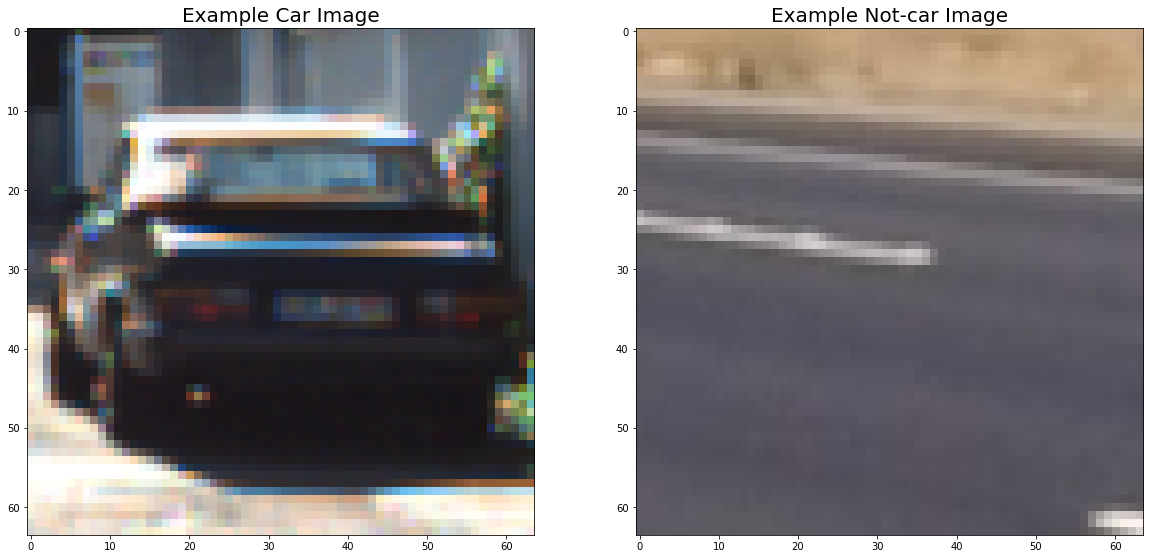

In [3]:
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image',fontsize=20)
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image',fontsize=20)
plt.savefig('output_images/Examples.png')

### Function block

In [4]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img,cv2.COLOR_RGB2HSV)

# Essentially a resize function
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))


def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


def find_cars(img, ystart, ystop, scale,
              svc, X_scaler, color_space,
              orient, pix_per_cell,
              cell_per_block, hog_channel,
              spatial_size,
              hist_bins, xlimit,all_rectangles=False):
    '''Extracts features from image and trains SVM model on those features.
    '''
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255
    rectangles = []
    
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2'+color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) +1
    nyblocks = (ch1.shape[0] // pix_per_cell) -1
    nfeat_per_block = orient * cell_per_block ** 2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    if hog_channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog1 = get_hog_features(hog_channel, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    
    for xb in range(xlimit,nxsteps):
        for yb in range(nysteps):
            
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            
            test_prediction = svc.predict(test_features)

            if test_prediction == 1 or all_rectangles:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                # It is best to save regions for now
                rectangles.append(((xbox_left, ytop_draw + ystart),
                                   (xbox_left + win_draw, ytop_draw + win_draw + ystart)))

    return rectangles

### Visualize HOG features

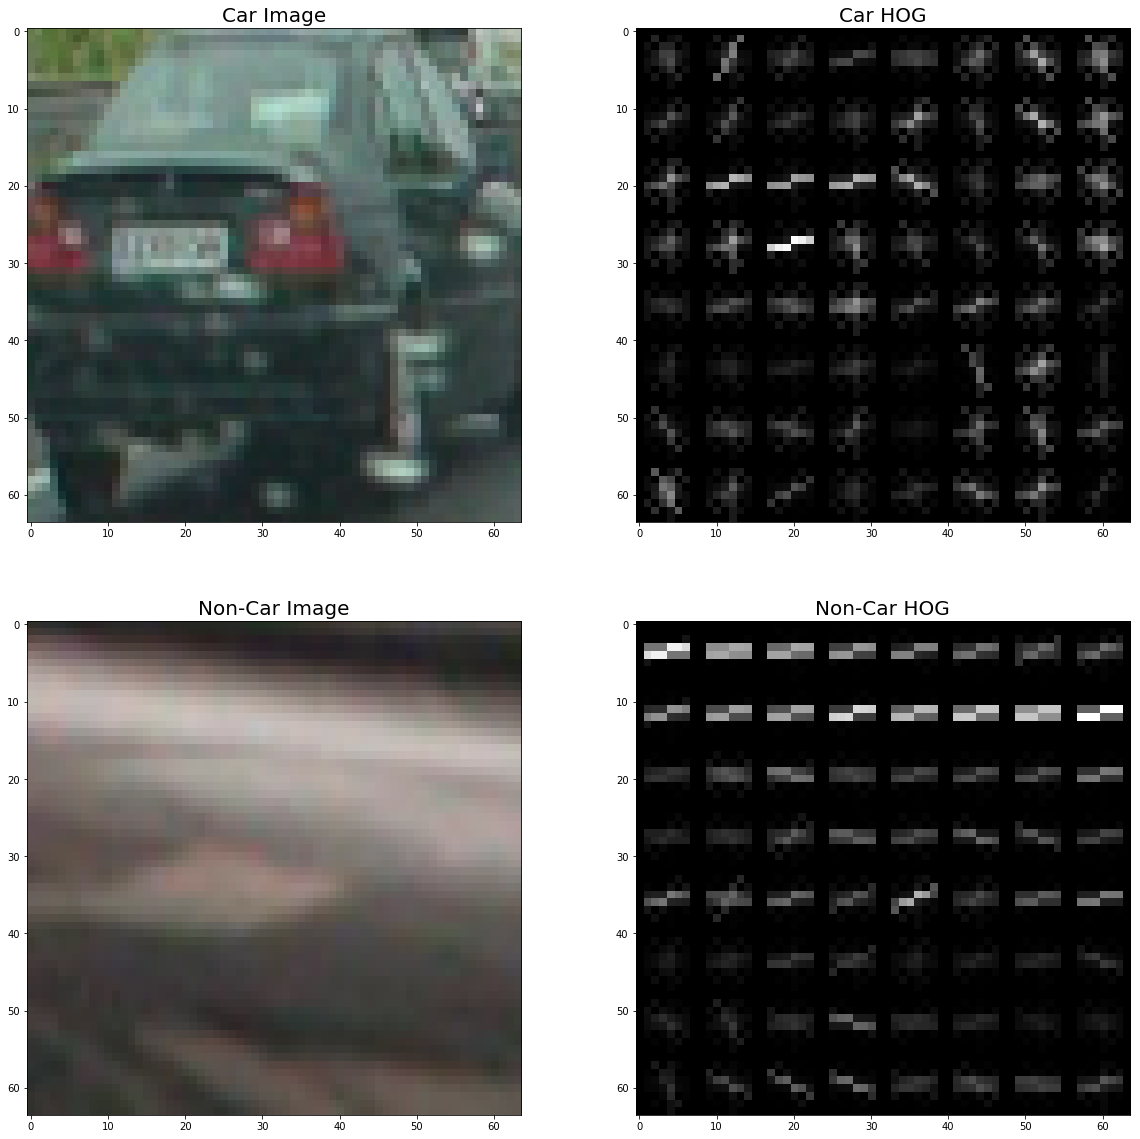

In [5]:
# Create random index point for each list of car and notcars filename
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in image from cars,notcars list using random indices from above
car_img = mpimg.imread(cars[car_ind])
noncar_img = mpimg.imread(notcars[notcar_ind])

# Create hog for the random images selected
features,car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
features,noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,20))
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=20)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=20)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=20)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=20)

### Feature extraction for model

In [6]:
# Define the settings used for the feature extraction
color_space='YCrCb'
orient=8
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'
spatial_size=(32, 32)
hist_bins=32
spatial_feat=True
hist_feat=True
hog_feat=True

t=time.time()
## Extract the features for all the car and not car images
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size,
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to extract features')

57.27859 Seconds to extract features


### Normalize and split dataset into testing and training set, then train the classifier

In [7]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = StandardScaler().fit(X).transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
# Use 20% test size

rand_state=np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial_size,
    'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 7872
13.71 Seconds to train SVC...
Test Accuracy of SVC =  0.9896
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  0.  1.  1.  1.]
0.00155 Seconds to predict 10 labels with SVC


### Show all potential search areas

The code block illustrates the overlapping regions that is being used to search for a car


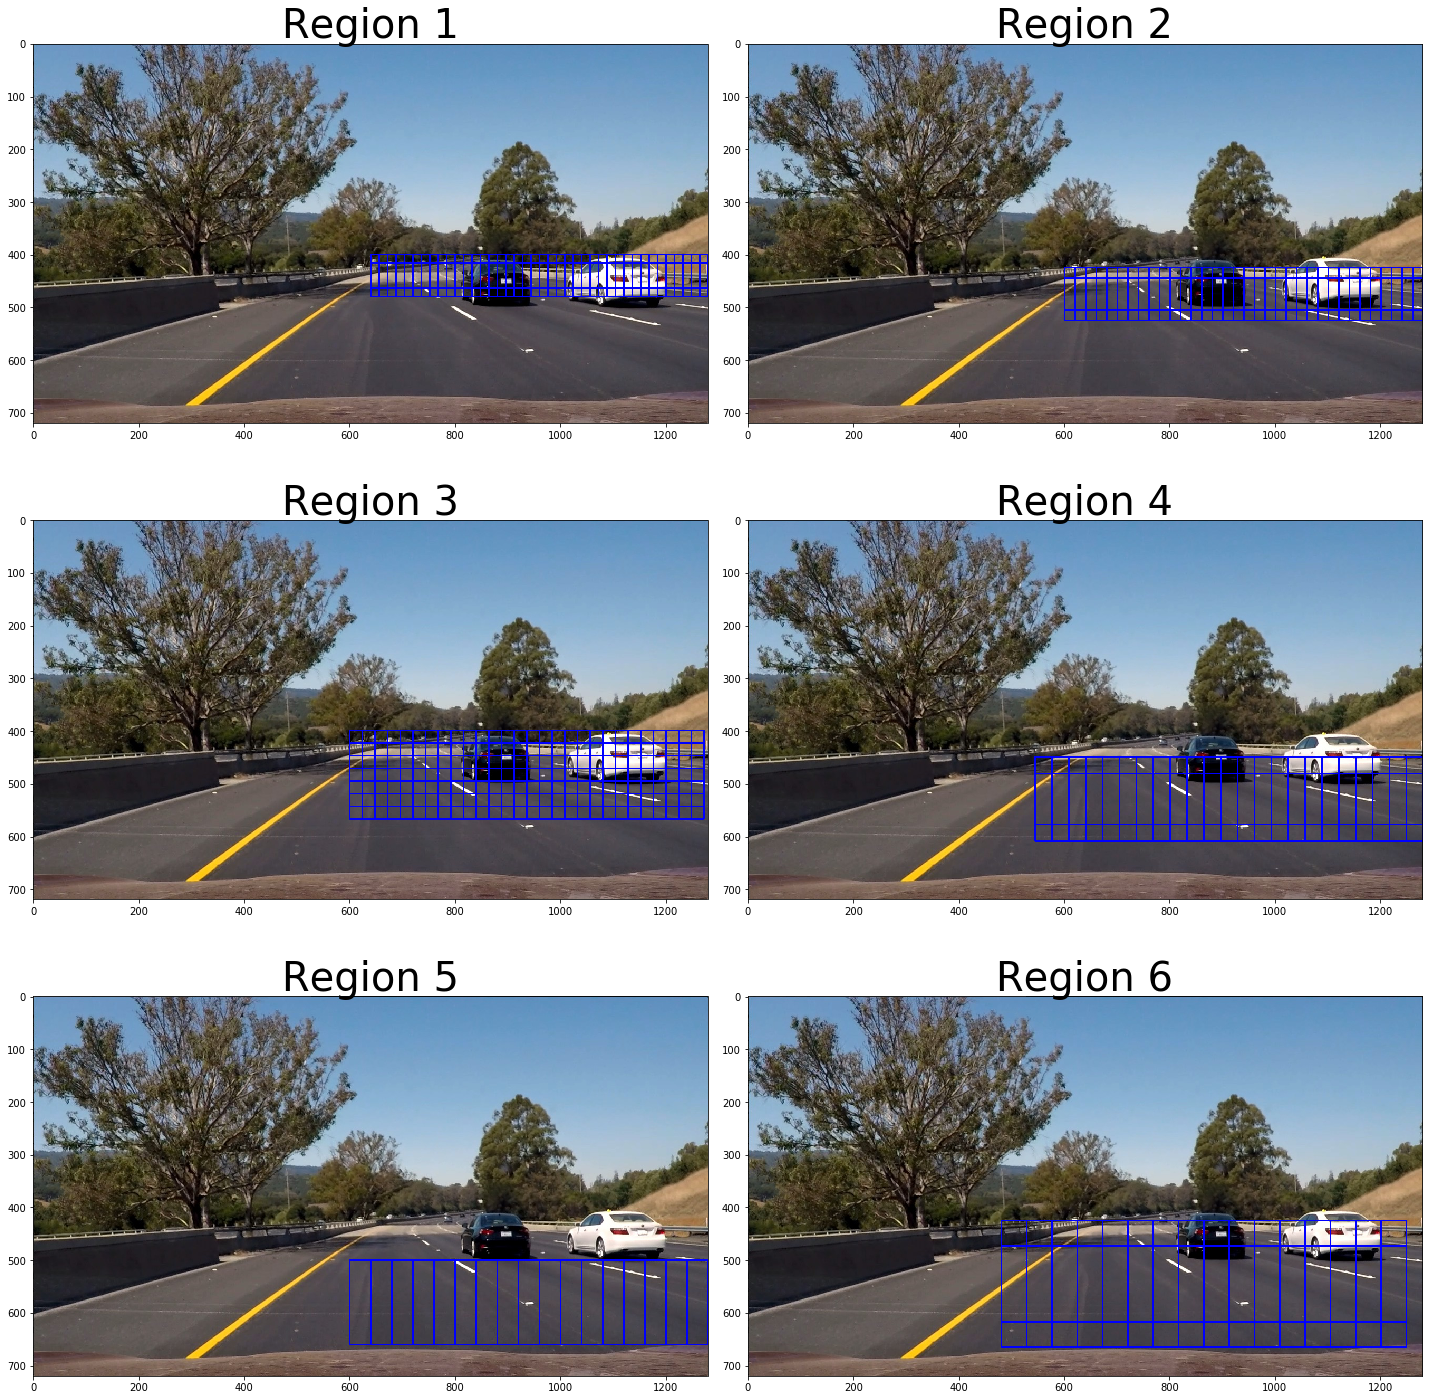

In [8]:
img = mpimg.imread('test_images/test6.jpg')

rects = []
y_start= [400,425,400,450,500,425]
y_stop = [500,550,600,650,700,725]
scale  = [1.0,1.25,1.5,2.0,2.5,3.0]
xlimit = [40,30,25,17,15,10]
num=1
fig= plt.figure(figsize=(20,20))

# Iterate in parallel y_start,y_stop_,scale. Draw each square regardless of detection

for ystart,ystop,scale,xlim in zip(y_start,y_stop,scale,xlimit):
    rect=find_cars(img, ystart, ystop, scale, svc,
                            X_scaler, color_space, orient,
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_size, hist_bins,xlim,all_rectangles=True)
    plot=draw_boxes(img,rect,thick=2)
    ax=fig.add_subplot(3,2,num,autoscale_on=True)
    ax.imshow(plot)
    ax.set_title('Region '+str(num),fontsize=40)
    rects.append(rect)
    num=num+1
plt.tight_layout()
plt.show()

### Regions that have detected a car

Note that not all regions overlap the cars in this specific test image, which is why Regions 4-6 have no boundary boxes in the image.

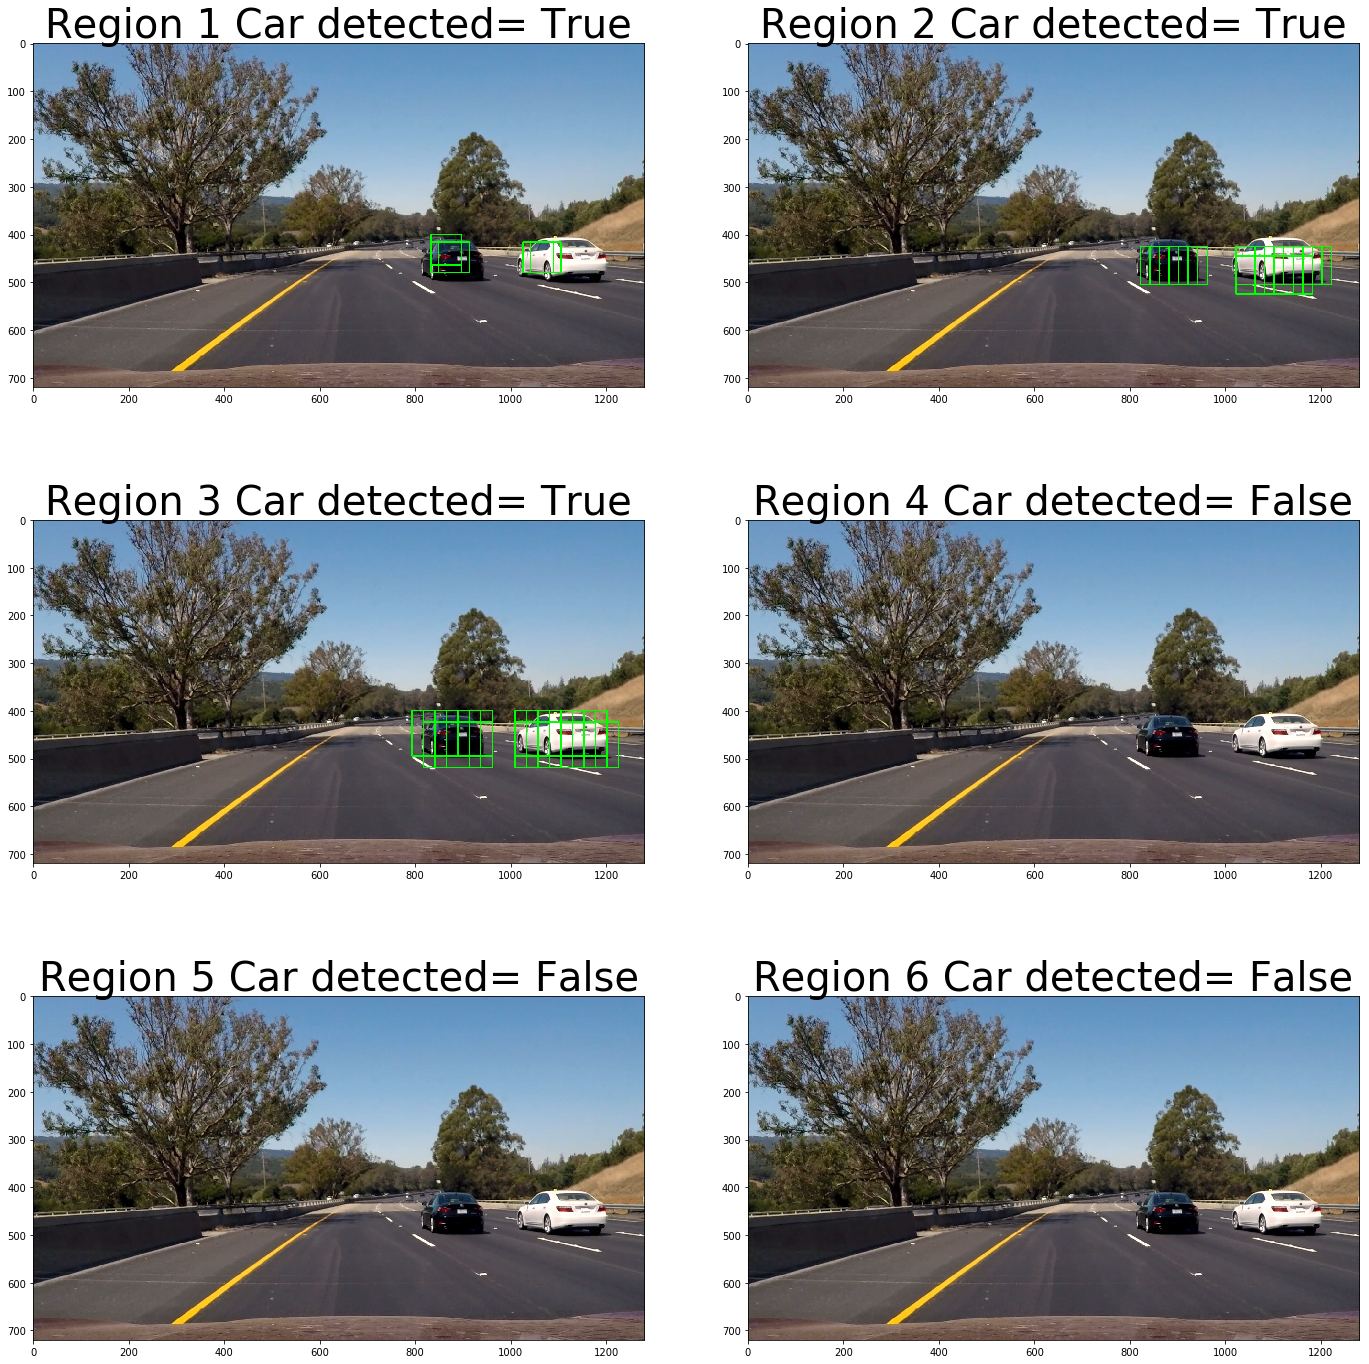

In [9]:
img = mpimg.imread('test_images/test6.jpg')

rects = []

# same settings as previous block, redundant, but used to clarify what is going on
y_start= [400,425,400,450,500,425]
y_stop = [500,550,600,650,700,725]
scale  = [1.0,1.25,1.5,2.0,2.5,3.0]
xlimit =  [40,30,25,17,15,10]

# Iterate in parallel y_start,y_stop_,scale. This time only drawing the rectangles that detect a car
num=1
fig= plt.figure(figsize=(20,20))
for ystart,ystop,scale,xlim in zip(y_start,y_stop,scale,xlimit):
    rect=find_cars(img, ystart, ystop, scale, svc,
                            X_scaler, color_space, orient,
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_size, hist_bins,xlim,all_rectangles=False)
    plot=draw_boxes(img,rect,color=(0,255,0),thick=2)
    ax=fig.add_subplot(3,2,num,autoscale_on=True)
    ax.imshow(plot)
    # If there are no boxes in rect then there were no cars detected in the region
    if len(rect)==0:
        detected='False'
    else:
        detected='True'
    ax.set_title('Region '+str(num)+' Car detected= '+detected,fontsize=40)
    rects.append(rect)
    num=num+1
plt.tight_layout()
plt.show()


### Closer look at Region 3

For this test image, region 3 seems to detect the cars in the image well.

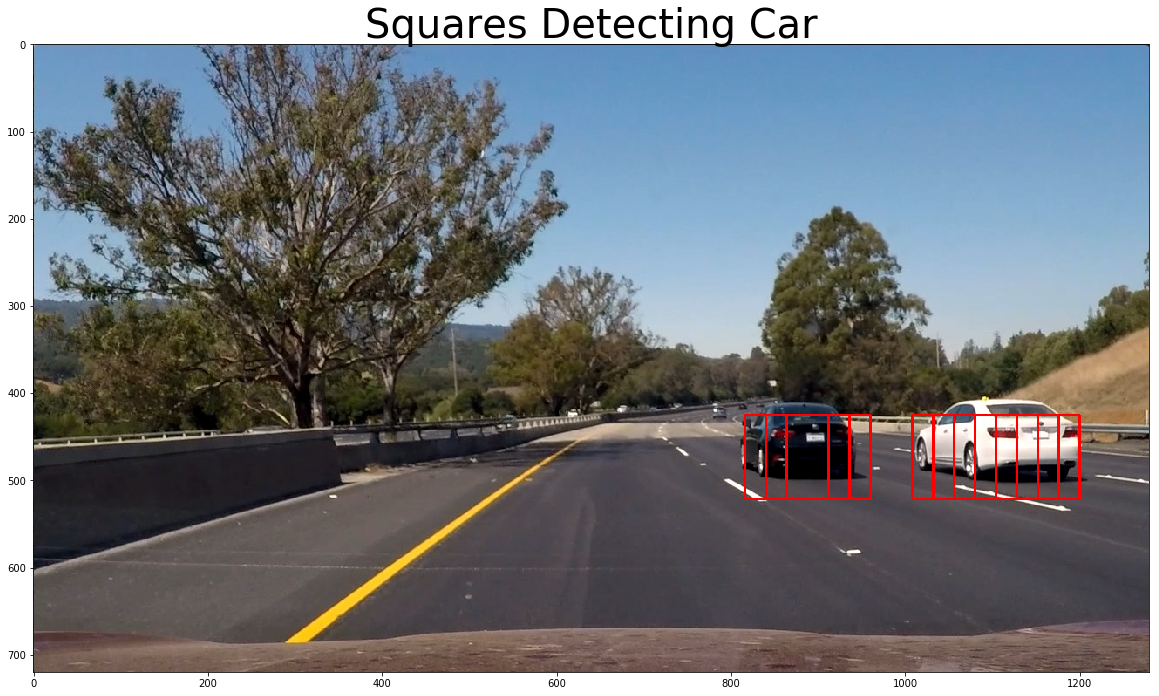

In [36]:
y_start = 400
y_stop = 600
scale = 1.5
xlimit =25

car_windows =find_cars(img, ystart, ystop, scale, svc,
                        X_scaler, color_space, orient,
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_size, hist_bins,xlim,all_rectangles=False)
test_img_rects = draw_boxes(img, car_windows,color=(255,0,0),thick=2)
plt.figure(figsize=(20,20))
plt.imshow(test_img_rects)
plt.title('Squares Detecting Car',fontsize=40)

### Add heat maps based on rectangles with car detected

In [14]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


### Plot the heatmap


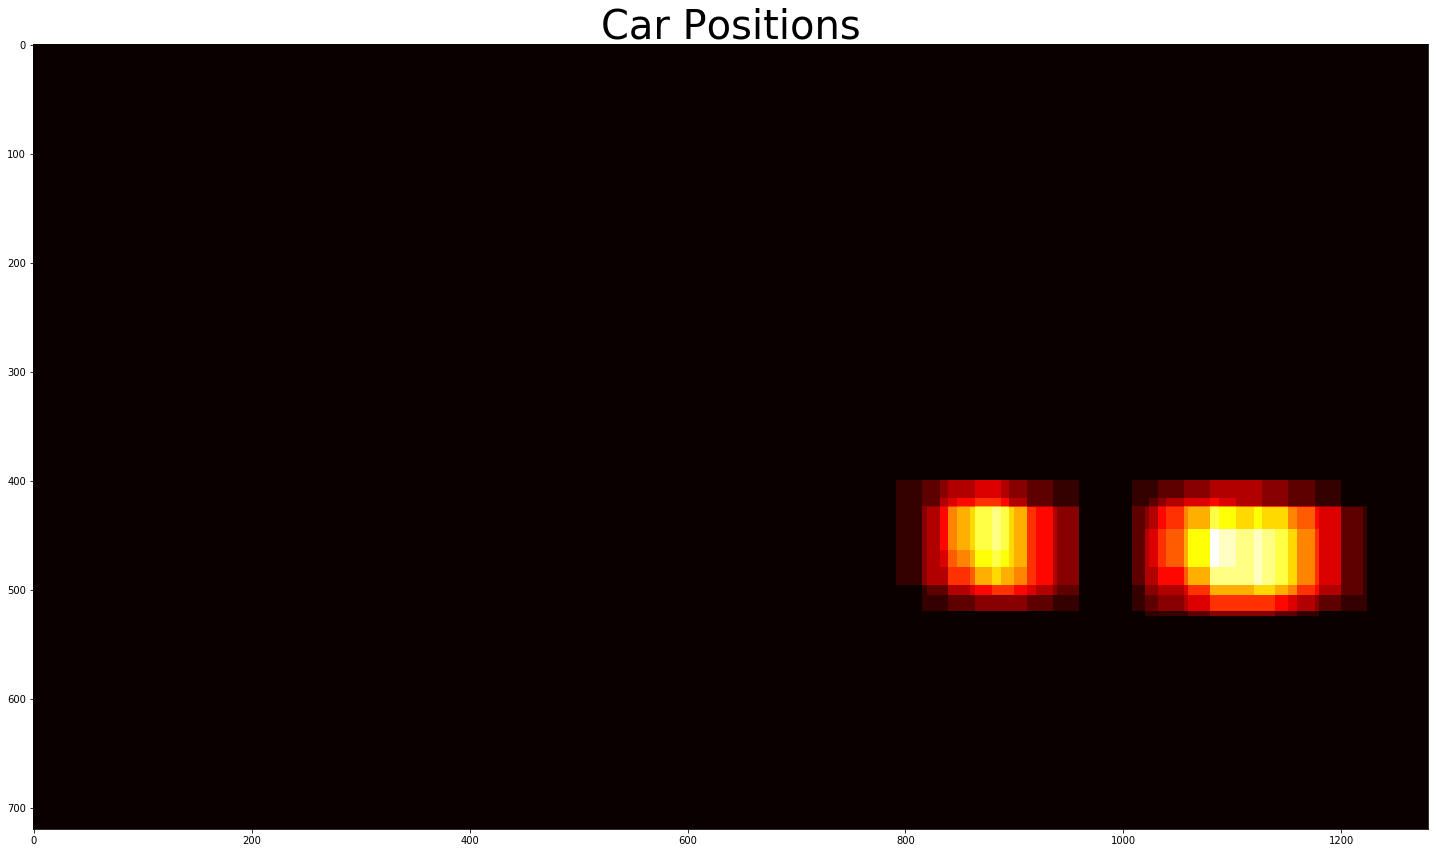

In [16]:
rects = []
y_start= [400,425,400,450,500,425]
y_stop = [500,550,600,650,700,725]
scale= [1.0,1.25,1.5,2.0,2.5,3.0]
xlimit =  [40,30,25,17,15,10]

# Iterate in parallel y_start,y_stop_,scale. This time only passing the rectangle valus to the add_heat function
for ystart,ystop,scale,xlim in zip(y_start,y_stop,scale,xlimit):
    rects.append(find_cars(img, ystart, ystop, scale, svc,
                            X_scaler, color_space, orient,
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_size, hist_bins,xlim))

rectangles = [item for sublist in rects for item in sublist]

heatmap_img = np.zeros_like(img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(25,25))
plt.imshow(heatmap_img, cmap='hot')
plt.title('Car Positions',fontsize=40)

### Apply a threshold  to the heatmap to filter false positives.

In [17]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

#### Filtering the heatmap
1. The edges of the heatmap are the most noticeable difference.
2. It has been observed that when training the classifer it has created false positives in the middle of the current lane. The threshold operation is a good countermeasure to reduce this chance in the final heatmap

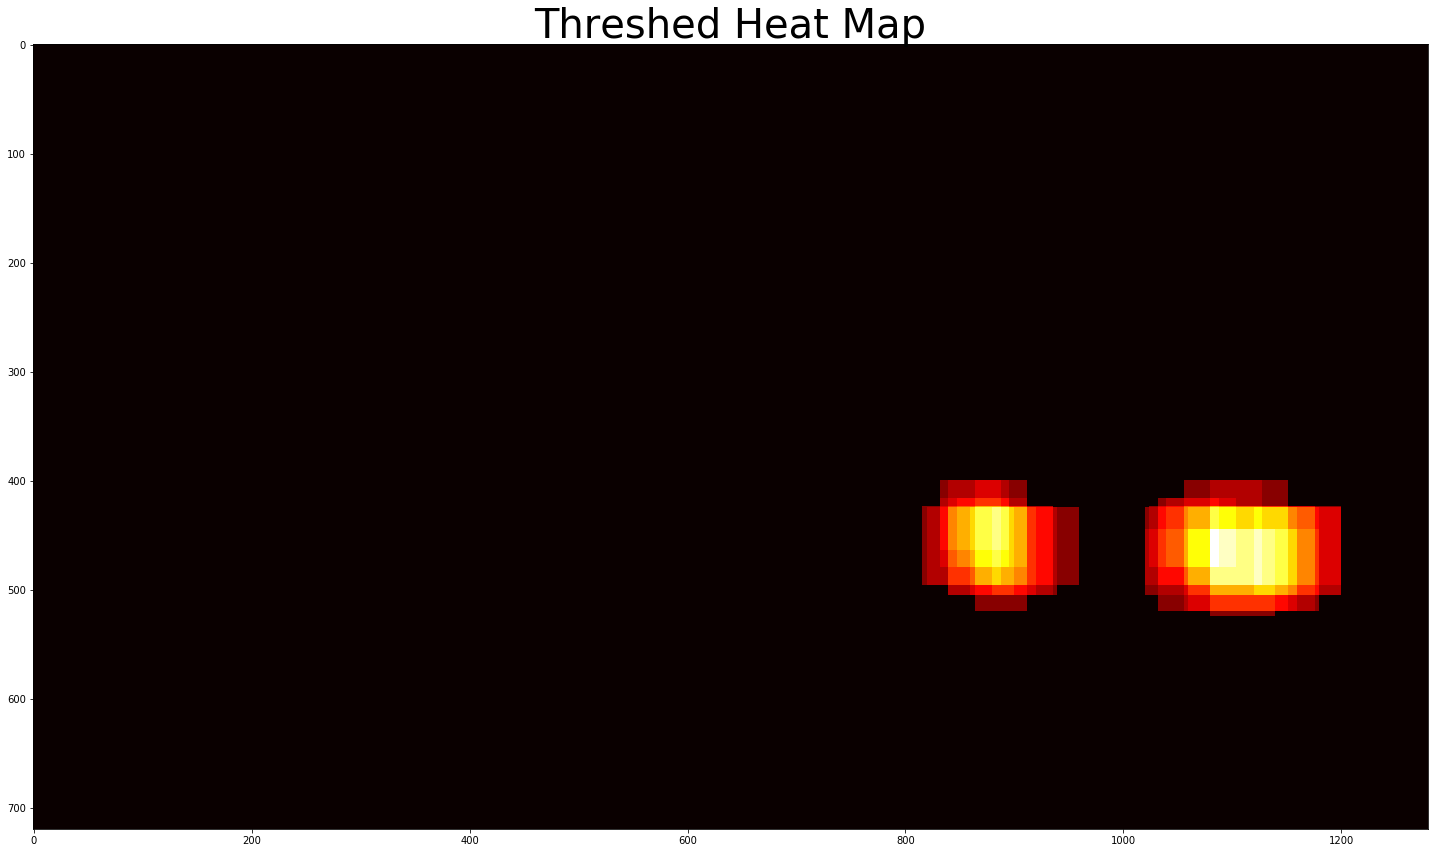

In [18]:
#Apply threshold and to filter false positives
#np.set_printoptions(suppress=True)
threshed_heatmap_img = apply_threshold(heatmap_img, 2)
plt.figure(figsize=(25,25))
plt.imshow(threshed_heatmap_img, cmap='hot')
plt.title('Threshed Heat Map',fontsize=40)

### Apply scipy labels to heatmap

2 cars found


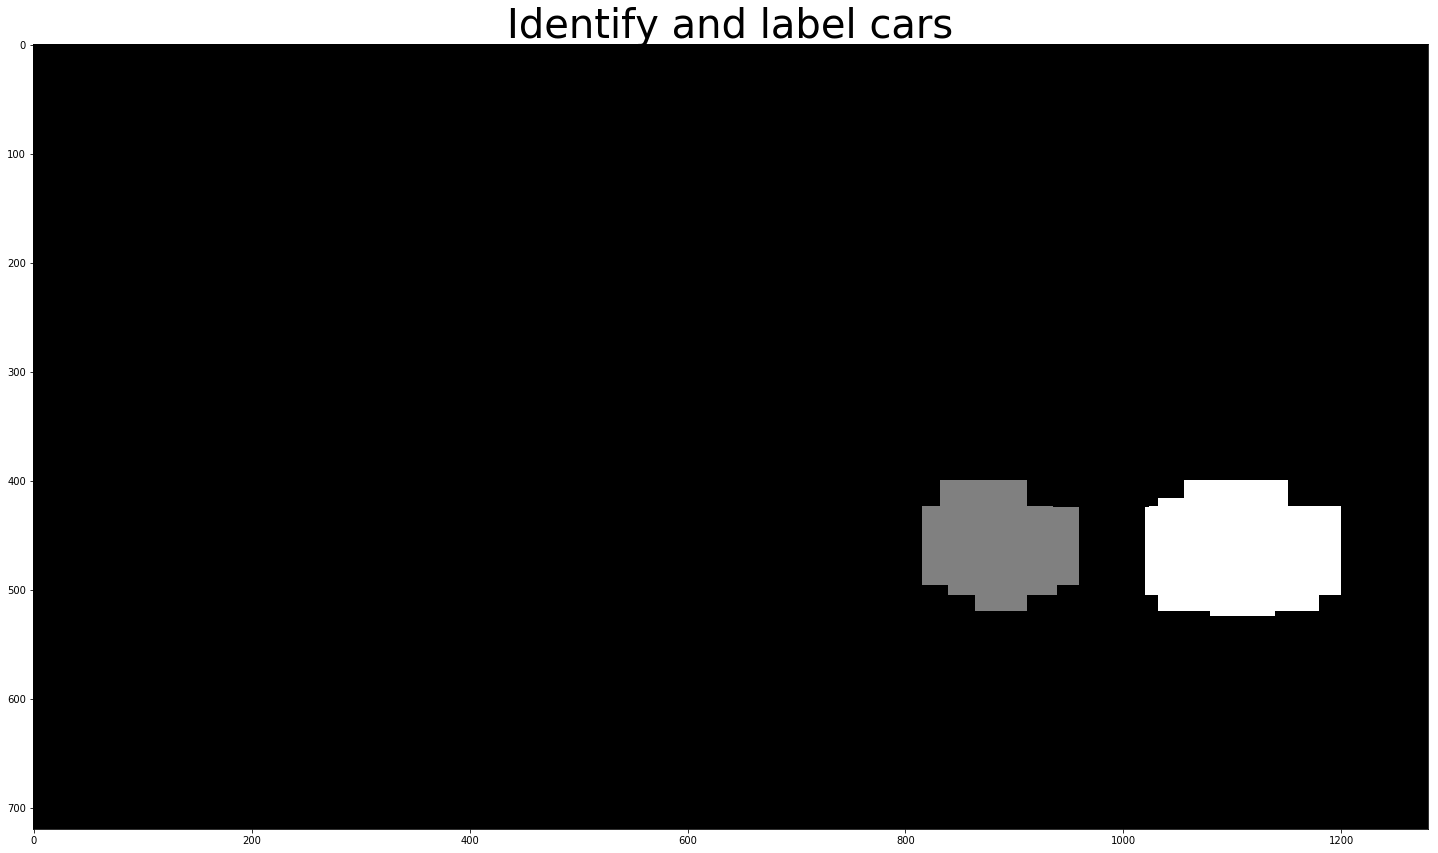

In [19]:
labels = label(threshed_heatmap_img)
plt.figure(figsize=(25,25))
plt.imshow(labels[0], cmap='gray')
plt.title('Identify and label cars',fontsize=40)
print(labels[1], 'cars found')

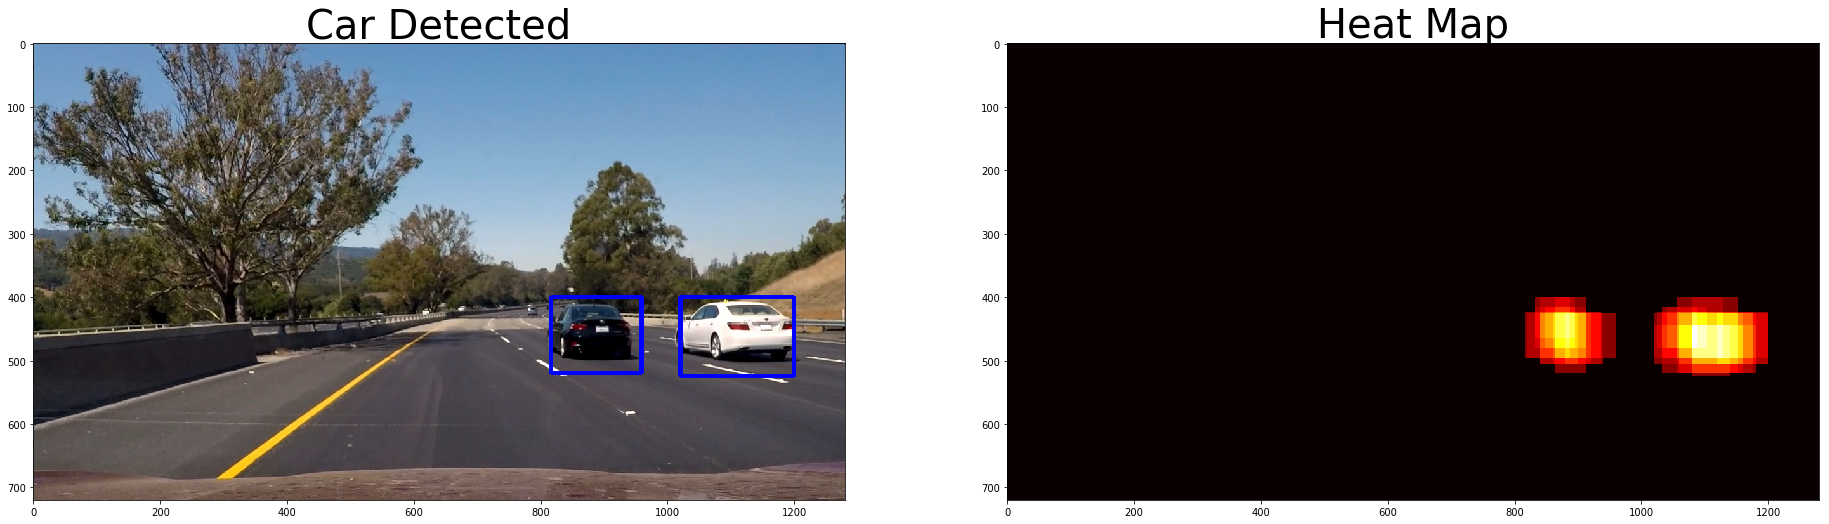

In [20]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
fig=plt.figure()
plt.figure(figsize=(32,24))
plt.subplot(1,2,1)
plt.imshow(draw_img)
plt.title('Car Detected',fontsize=40)
plt.subplot(1,2,2)
plt.imshow(heatmap_img,cmap='hot')
plt.title('Heat Map',fontsize=40)
plt.savefig('output_images/plotcompare.png')

### Vehicle detection pipeline single image

In [23]:
#This pipeline is for single images.


def vehicle_detection_pipeline(img):
    rects = []
    y_start = [400,425,400,450,500,425]
    y_stop  = [500,550,600,650,700,725]
    scale   = [1.0,1.25,1.5,2.0,2.5,3.0]
    xlimit =  [40,30,25,17,15,10]

    # Iterate in parallel y_start,y_stop_,scale. This time only passing the rectangle valus to the add_heat function
    for ystart,ystop,scale,xlim in zip(y_start,y_stop,scale,xlimit):
        rects.append(find_cars(img, ystart, ystop, scale, svc,
                                X_scaler, color_space, orient,
                                pix_per_cell, cell_per_block, hog_channel,
                                spatial_size, hist_bins,xlim))

    rectangles = [item for sublist in rects for item in sublist]
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 3)
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

### Detect cars on test images

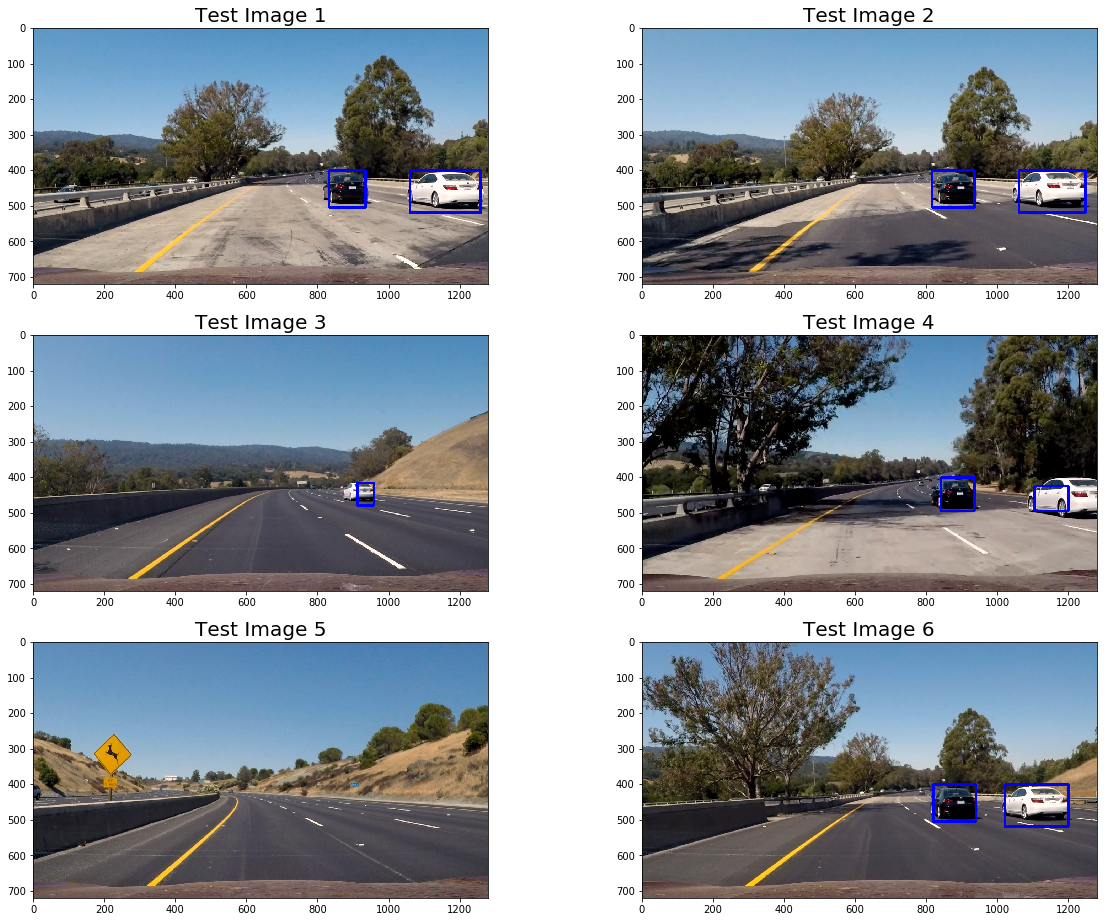

In [24]:
fig = plt.figure(figsize=(20,16))
f.tight_layout()
for i in range(len(test_images)):
    _img = mpimg.imread(test_images[i])
    test_img=vehicle_detection_pipeline(_img)
    ax=fig.add_subplot(3,2,i+1)
    ax.imshow(test_img)
    ax.set_title('Test Image '+str(i+1),fontsize=20)
plt.show()

### Vehicle detection pipeline for video

In [42]:
#Similar to the single image pipeline but this incorporates memory system that remembers the last 8 frames
prev_frames=deque(maxlen=8)

def vehicle_detection_pipeline_video(img):
    rects = []
    y_start = [410,400,425,400,450,500,425]
    y_stop  = [460,500,550,600,650,700,725]
    scale   = [1.15,1.0,1.25,1.5,2.0,2.5,3.0]
    xlimit =  [40,30,25,17,15,10]
    start=time.time()
    for ystart,ystop,scale,xlim in zip(y_start,y_stop,scale,xlimit):
        rects.append(find_cars(img, ystart, ystop, scale, svc,
                                X_scaler, color_space, orient,
                                pix_per_cell, cell_per_block, hog_channel,
                                spatial_size, hist_bins,xlim))

    rectangles = [item for sublist in rects for item in sublist]
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 3) # threshold op1
    
    prev_frames.append(heatmap_img)#add current heatmap to memory
    heatmap_img=sum(prev_frames)# calc new heatmap_img that uses last 8 frames
    
    heatmap_img = apply_threshold(heatmap_img,2) # threshold op2
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    end=time.time()
    print('Seconds between frames ',round(end-start,5))
    return draw_img

### Find cars in project video

In [43]:
output = 'Proj_5.mp4'
clip_test = VideoFileClip('project_video.mp4')#.subclip(10,30)
clip_test_out = clip_test.fl_image(vehicle_detection_pipeline_video)
%time clip_test_out.write_videofile(output, audio=False)

Seconds between frames  0.45405
[MoviePy] >>>> Building video Proj_5.mp4
[MoviePy] Writing video Proj_5.mp4



  0%|          | 1/1261 [00:00<09:24,  2.23it/s]

Seconds between frames  0.44639



  0%|          | 2/1261 [00:00<09:36,  2.19it/s]

Seconds between frames  0.47626



  0%|          | 3/1261 [00:01<09:33,  2.19it/s]

Seconds between frames  0.44925



  0%|          | 4/1261 [00:01<09:31,  2.20it/s]

Seconds between frames  0.44869



  0%|          | 5/1261 [00:02<09:27,  2.21it/s]

Seconds between frames  0.44307



  0%|          | 6/1261 [00:02<09:26,  2.21it/s]

Seconds between frames  0.44878



  1%|          | 7/1261 [00:03<09:27,  2.21it/s]

Seconds between frames  0.45182



  1%|          | 8/1261 [00:03<09:34,  2.18it/s]

Seconds between frames  0.47029



  1%|          | 9/1261 [00:04<09:39,  2.16it/s]

Seconds between frames  0.47046



  1%|          | 10/1261 [00:04<09:40,  2.16it/s]

Seconds between frames  0.46296



  1%|          | 11/1261 [00:05<09:46,  2.13it/s]

Seconds between frames  0.47924



  1%|          | 12/1261 [00:05<09:43,  2.14it/s]

Seconds between frames  0.45789



  1%|          | 13/1261 [00:05<09:39,  2.15it/s]

Seconds between frames  0.45471



  1%|          | 14/1261 [00:06<09:33,  2.17it/s]

Seconds between frames  0.44485



  1%|          | 15/1261 [00:06<09:39,  2.15it/s]

Seconds between frames  0.47586



  1%|▏         | 16/1261 [00:07<09:42,  2.14it/s]

Seconds between frames  0.47023



  1%|▏         | 17/1261 [00:07<09:36,  2.16it/s]

Seconds between frames  0.44915



  1%|▏         | 18/1261 [00:08<09:39,  2.14it/s]

Seconds between frames  0.46902



  2%|▏         | 19/1261 [00:08<09:32,  2.17it/s]

Seconds between frames  0.44612



  2%|▏         | 20/1261 [00:09<09:35,  2.15it/s]

Seconds between frames  0.46761



  2%|▏         | 21/1261 [00:09<09:36,  2.15it/s]

Seconds between frames  0.46403



  2%|▏         | 22/1261 [00:10<09:43,  2.12it/s]

Seconds between frames  0.48193



  2%|▏         | 23/1261 [00:10<09:47,  2.11it/s]

Seconds between frames  0.47995



  2%|▏         | 24/1261 [00:11<09:39,  2.14it/s]

Seconds between frames  0.45124



  2%|▏         | 25/1261 [00:11<09:47,  2.10it/s]

Seconds between frames  0.48871



  2%|▏         | 26/1261 [00:12<09:47,  2.10it/s]

Seconds between frames  0.47019



  2%|▏         | 27/1261 [00:12<10:10,  2.02it/s]

Seconds between frames  0.53657



  2%|▏         | 28/1261 [00:13<10:09,  2.02it/s]

Seconds between frames  0.48855



  2%|▏         | 29/1261 [00:13<09:52,  2.08it/s]

Seconds between frames  0.44523



  2%|▏         | 30/1261 [00:14<09:54,  2.07it/s]

Seconds between frames  0.48432



  2%|▏         | 31/1261 [00:14<09:47,  2.09it/s]

Seconds between frames  0.46209



  3%|▎         | 32/1261 [00:15<09:46,  2.09it/s]

Seconds between frames  0.47384



  3%|▎         | 33/1261 [00:15<09:39,  2.12it/s]

Seconds between frames  0.45633



  3%|▎         | 34/1261 [00:15<09:40,  2.12it/s]

Seconds between frames  0.47175



  3%|▎         | 35/1261 [00:16<09:29,  2.15it/s]

Seconds between frames  0.44318



  3%|▎         | 36/1261 [00:16<09:29,  2.15it/s]

Seconds between frames  0.46116



  3%|▎         | 37/1261 [00:17<09:25,  2.16it/s]

Seconds between frames  0.45229



  3%|▎         | 38/1261 [00:17<09:23,  2.17it/s]

Seconds between frames  0.45282



  3%|▎         | 39/1261 [00:18<09:21,  2.18it/s]

Seconds between frames  0.45385



  3%|▎         | 40/1261 [00:18<09:28,  2.15it/s]

Seconds between frames  0.47629



  3%|▎         | 41/1261 [00:19<09:20,  2.18it/s]

Seconds between frames  0.44371



  3%|▎         | 42/1261 [00:19<09:21,  2.17it/s]

Seconds between frames  0.46071



  3%|▎         | 43/1261 [00:20<09:21,  2.17it/s]

Seconds between frames  0.45874



  3%|▎         | 44/1261 [00:20<09:21,  2.17it/s]

Seconds between frames  0.45825



  4%|▎         | 45/1261 [00:20<09:19,  2.17it/s]

Seconds between frames  0.45414



  4%|▎         | 46/1261 [00:21<09:18,  2.17it/s]

Seconds between frames  0.45692



  4%|▎         | 47/1261 [00:21<09:33,  2.12it/s]

Seconds between frames  0.49638



  4%|▍         | 48/1261 [00:22<09:32,  2.12it/s]

Seconds between frames  0.46623



  4%|▍         | 49/1261 [00:22<09:28,  2.13it/s]

Seconds between frames  0.45933



  4%|▍         | 50/1261 [00:23<09:39,  2.09it/s]

Seconds between frames  0.49808



  4%|▍         | 51/1261 [00:23<09:37,  2.09it/s]

Seconds between frames  0.47071



  4%|▍         | 52/1261 [00:24<10:02,  2.01it/s]

Seconds between frames  0.54365



  4%|▍         | 53/1261 [00:24<10:10,  1.98it/s]

Seconds between frames  0.5192



  4%|▍         | 54/1261 [00:25<10:13,  1.97it/s]

Seconds between frames  0.512



  4%|▍         | 55/1261 [00:25<09:58,  2.02it/s]

Seconds between frames  0.46444



  4%|▍         | 56/1261 [00:26<09:44,  2.06it/s]

Seconds between frames  0.455



  5%|▍         | 57/1261 [00:26<09:41,  2.07it/s]

Seconds between frames  0.47546



  5%|▍         | 58/1261 [00:27<09:36,  2.09it/s]

Seconds between frames  0.46609



  5%|▍         | 59/1261 [00:27<09:27,  2.12it/s]

Seconds between frames  0.45374



  5%|▍         | 60/1261 [00:28<09:20,  2.14it/s]

Seconds between frames  0.45033



  5%|▍         | 61/1261 [00:28<09:20,  2.14it/s]

Seconds between frames  0.46489



  5%|▍         | 62/1261 [00:29<09:22,  2.13it/s]

Seconds between frames  0.47145



  5%|▍         | 63/1261 [00:29<09:21,  2.13it/s]

Seconds between frames  0.46547



  5%|▌         | 64/1261 [00:30<09:23,  2.12it/s]

Seconds between frames  0.47259



  5%|▌         | 65/1261 [00:30<09:13,  2.16it/s]

Seconds between frames  0.44129



  5%|▌         | 66/1261 [00:31<09:05,  2.19it/s]

Seconds between frames  0.43949



  5%|▌         | 67/1261 [00:31<09:05,  2.19it/s]

Seconds between frames  0.45502



  5%|▌         | 68/1261 [00:31<09:03,  2.20it/s]

Seconds between frames  0.44895



  5%|▌         | 69/1261 [00:32<09:13,  2.15it/s]

Seconds between frames  0.4821



  6%|▌         | 70/1261 [00:32<09:22,  2.12it/s]

Seconds between frames  0.4888



  6%|▌         | 71/1261 [00:33<09:33,  2.07it/s]

Seconds between frames  0.50235



  6%|▌         | 72/1261 [00:33<09:31,  2.08it/s]

Seconds between frames  0.47452



  6%|▌         | 73/1261 [00:34<09:33,  2.07it/s]

Seconds between frames  0.47973



  6%|▌         | 74/1261 [00:34<09:31,  2.08it/s]

Seconds between frames  0.47525



  6%|▌         | 75/1261 [00:35<09:24,  2.10it/s]

Seconds between frames  0.46086



  6%|▌         | 76/1261 [00:35<09:15,  2.13it/s]

Seconds between frames  0.44812



  6%|▌         | 77/1261 [00:36<09:30,  2.08it/s]

Seconds between frames  0.50931



  6%|▌         | 78/1261 [00:36<09:23,  2.10it/s]

Seconds between frames  0.46002



  6%|▋         | 79/1261 [00:37<09:21,  2.10it/s]

Seconds between frames  0.47009



  6%|▋         | 80/1261 [00:37<09:31,  2.07it/s]

Seconds between frames  0.50041



  6%|▋         | 81/1261 [00:38<09:23,  2.09it/s]

Seconds between frames  0.45991



  7%|▋         | 82/1261 [00:38<09:15,  2.12it/s]

Seconds between frames  0.45443



  7%|▋         | 83/1261 [00:39<09:28,  2.07it/s]

Seconds between frames  0.50194



  7%|▋         | 84/1261 [00:39<10:01,  1.96it/s]

Seconds between frames  0.57372



  7%|▋         | 85/1261 [00:40<10:21,  1.89it/s]

Seconds between frames  0.56724



  7%|▋         | 86/1261 [00:40<10:58,  1.78it/s]

Seconds between frames  0.63084



  7%|▋         | 87/1261 [00:41<10:33,  1.85it/s]

Seconds between frames  0.48729



  7%|▋         | 88/1261 [00:41<10:12,  1.91it/s]

Seconds between frames  0.47953



  7%|▋         | 89/1261 [00:42<10:04,  1.94it/s]

Seconds between frames  0.49636



  7%|▋         | 90/1261 [00:42<10:01,  1.95it/s]

Seconds between frames  0.50399



  7%|▋         | 91/1261 [00:43<10:08,  1.92it/s]

Seconds between frames  0.53269



  7%|▋         | 92/1261 [00:43<09:44,  2.00it/s]

Seconds between frames  0.45155



  7%|▋         | 93/1261 [00:44<09:46,  1.99it/s]

Seconds between frames  0.50239



  7%|▋         | 94/1261 [00:44<09:25,  2.06it/s]

Seconds between frames  0.4405



  8%|▊         | 95/1261 [00:45<09:26,  2.06it/s]

Seconds between frames  0.48513



  8%|▊         | 96/1261 [00:45<09:15,  2.10it/s]

Seconds between frames  0.45137



  8%|▊         | 97/1261 [00:46<09:08,  2.12it/s]

Seconds between frames  0.45714



  8%|▊         | 98/1261 [00:46<09:10,  2.11it/s]

Seconds between frames  0.47379



  8%|▊         | 99/1261 [00:47<09:14,  2.10it/s]

Seconds between frames  0.48452



  8%|▊         | 100/1261 [00:47<09:07,  2.12it/s]

Seconds between frames  0.45621



  8%|▊         | 101/1261 [00:48<09:20,  2.07it/s]

Seconds between frames  0.50747



  8%|▊         | 102/1261 [00:48<09:25,  2.05it/s]

Seconds between frames  0.49715



  8%|▊         | 103/1261 [00:49<09:32,  2.02it/s]

Seconds between frames  0.50582



  8%|▊         | 104/1261 [00:49<09:37,  2.00it/s]

Seconds between frames  0.50687



  8%|▊         | 105/1261 [00:50<09:45,  1.98it/s]

Seconds between frames  0.51988



  8%|▊         | 106/1261 [00:50<09:42,  1.98it/s]

Seconds between frames  0.49536



  8%|▊         | 107/1261 [00:51<09:30,  2.02it/s]

Seconds between frames  0.47012



  9%|▊         | 108/1261 [00:51<09:16,  2.07it/s]

Seconds between frames  0.4514



  9%|▊         | 109/1261 [00:52<09:12,  2.08it/s]

Seconds between frames  0.4696



  9%|▊         | 110/1261 [00:52<09:09,  2.09it/s]

Seconds between frames  0.46957



  9%|▉         | 111/1261 [00:53<09:10,  2.09it/s]

Seconds between frames  0.4785



  9%|▉         | 112/1261 [00:53<09:16,  2.06it/s]

Seconds between frames  0.49418



  9%|▉         | 113/1261 [00:54<09:12,  2.08it/s]

Seconds between frames  0.47076



  9%|▉         | 114/1261 [00:54<09:04,  2.10it/s]

Seconds between frames  0.45768



  9%|▉         | 115/1261 [00:54<08:58,  2.13it/s]

Seconds between frames  0.45545



  9%|▉         | 116/1261 [00:55<09:08,  2.09it/s]

Seconds between frames  0.49814



  9%|▉         | 117/1261 [00:55<09:07,  2.09it/s]

Seconds between frames  0.47465



  9%|▉         | 118/1261 [00:56<09:09,  2.08it/s]

Seconds between frames  0.48155



  9%|▉         | 119/1261 [00:56<09:01,  2.11it/s]

Seconds between frames  0.45818



 10%|▉         | 120/1261 [00:57<08:58,  2.12it/s]

Seconds between frames  0.4619



 10%|▉         | 121/1261 [00:57<09:07,  2.08it/s]

Seconds between frames  0.4979



 10%|▉         | 122/1261 [00:58<09:20,  2.03it/s]

Seconds between frames  0.51615



 10%|▉         | 123/1261 [00:58<09:18,  2.04it/s]

Seconds between frames  0.48573



 10%|▉         | 124/1261 [00:59<09:23,  2.02it/s]

Seconds between frames  0.50205



 10%|▉         | 125/1261 [00:59<09:32,  1.99it/s]

Seconds between frames  0.5202



 10%|▉         | 126/1261 [01:00<09:27,  2.00it/s]

Seconds between frames  0.48829



 10%|█         | 127/1261 [01:00<09:09,  2.06it/s]

Seconds between frames  0.44563



 10%|█         | 128/1261 [01:01<09:01,  2.09it/s]

Seconds between frames  0.45881



 10%|█         | 129/1261 [01:01<09:01,  2.09it/s]

Seconds between frames  0.47858



 10%|█         | 130/1261 [01:02<08:51,  2.13it/s]

Seconds between frames  0.44605



 10%|█         | 131/1261 [01:02<08:47,  2.14it/s]

Seconds between frames  0.45752



 10%|█         | 132/1261 [01:03<08:49,  2.13it/s]

Seconds between frames  0.47168



 11%|█         | 133/1261 [01:03<08:55,  2.11it/s]

Seconds between frames  0.48484



 11%|█         | 134/1261 [01:04<08:58,  2.09it/s]

Seconds between frames  0.48168



 11%|█         | 135/1261 [01:04<08:51,  2.12it/s]

Seconds between frames  0.45541



 11%|█         | 136/1261 [01:05<08:50,  2.12it/s]

Seconds between frames  0.4673



 11%|█         | 137/1261 [01:05<08:49,  2.12it/s]

Seconds between frames  0.46365



 11%|█         | 138/1261 [01:06<08:54,  2.10it/s]

Seconds between frames  0.48374



 11%|█         | 139/1261 [01:06<08:50,  2.11it/s]

Seconds between frames  0.46499



 11%|█         | 140/1261 [01:06<09:03,  2.06it/s]

Seconds between frames  0.50928



 11%|█         | 141/1261 [01:07<08:54,  2.10it/s]

Seconds between frames  0.45638



 11%|█▏        | 142/1261 [01:07<08:47,  2.12it/s]

Seconds between frames  0.45512



 11%|█▏        | 143/1261 [01:08<08:48,  2.12it/s]

Seconds between frames  0.47236



 11%|█▏        | 144/1261 [01:08<08:42,  2.14it/s]

Seconds between frames  0.45198



 11%|█▏        | 145/1261 [01:09<08:47,  2.12it/s]

Seconds between frames  0.48198



 12%|█▏        | 146/1261 [01:09<08:58,  2.07it/s]

Seconds between frames  0.50608



 12%|█▏        | 147/1261 [01:10<08:53,  2.09it/s]

Seconds between frames  0.46591



 12%|█▏        | 148/1261 [01:10<08:44,  2.12it/s]

Seconds between frames  0.44946



 12%|█▏        | 149/1261 [01:11<08:39,  2.14it/s]

Seconds between frames  0.45521



 12%|█▏        | 150/1261 [01:11<09:05,  2.04it/s]

Seconds between frames  0.54387



 12%|█▏        | 151/1261 [01:12<09:00,  2.05it/s]

Seconds between frames  0.47293



 12%|█▏        | 152/1261 [01:12<08:46,  2.11it/s]

Seconds between frames  0.44235



 12%|█▏        | 153/1261 [01:13<08:49,  2.09it/s]

Seconds between frames  0.48097



 12%|█▏        | 154/1261 [01:13<08:43,  2.11it/s]

Seconds between frames  0.45698



 12%|█▏        | 155/1261 [01:14<09:08,  2.02it/s]

Seconds between frames  0.54692



 12%|█▏        | 156/1261 [01:14<09:04,  2.03it/s]

Seconds between frames  0.48253



 12%|█▏        | 157/1261 [01:15<09:13,  2.00it/s]

Seconds between frames  0.51704



 13%|█▎        | 158/1261 [01:15<09:25,  1.95it/s]

Seconds between frames  0.53507



 13%|█▎        | 159/1261 [01:16<09:42,  1.89it/s]

Seconds between frames  0.5626



 13%|█▎        | 160/1261 [01:16<09:48,  1.87it/s]

Seconds between frames  0.54551



 13%|█▎        | 161/1261 [01:17<09:45,  1.88it/s]

Seconds between frames  0.52369



 13%|█▎        | 162/1261 [01:17<09:52,  1.85it/s]

Seconds between frames  0.55245



 13%|█▎        | 163/1261 [01:18<09:54,  1.85it/s]

Seconds between frames  0.54403



 13%|█▎        | 164/1261 [01:18<09:33,  1.91it/s]

Seconds between frames  0.4754



 13%|█▎        | 165/1261 [01:19<09:33,  1.91it/s]

Seconds between frames  0.5204



 13%|█▎        | 166/1261 [01:19<09:31,  1.92it/s]

Seconds between frames  0.5151



 13%|█▎        | 167/1261 [01:20<09:18,  1.96it/s]

Seconds between frames  0.47913



 13%|█▎        | 168/1261 [01:20<09:19,  1.95it/s]

Seconds between frames  0.51224



 13%|█▎        | 169/1261 [01:21<09:08,  1.99it/s]

Seconds between frames  0.47893



 13%|█▎        | 170/1261 [01:21<09:03,  2.01it/s]

Seconds between frames  0.48475



 14%|█▎        | 171/1261 [01:22<08:51,  2.05it/s]

Seconds between frames  0.45736



 14%|█▎        | 172/1261 [01:22<08:49,  2.06it/s]

Seconds between frames  0.47849



 14%|█▎        | 173/1261 [01:23<08:56,  2.03it/s]

Seconds between frames  0.50682



 14%|█▍        | 174/1261 [01:23<08:59,  2.01it/s]

Seconds between frames  0.5012



 14%|█▍        | 175/1261 [01:24<08:59,  2.01it/s]

Seconds between frames  0.49121



 14%|█▍        | 176/1261 [01:24<08:51,  2.04it/s]

Seconds between frames  0.47067



 14%|█▍        | 177/1261 [01:25<08:59,  2.01it/s]

Seconds between frames  0.51308



 14%|█▍        | 178/1261 [01:25<08:47,  2.05it/s]

Seconds between frames  0.45691



 14%|█▍        | 179/1261 [01:26<08:53,  2.03it/s]

Seconds between frames  0.50348



 14%|█▍        | 180/1261 [01:26<09:03,  1.99it/s]

Seconds between frames  0.52067



 14%|█▍        | 181/1261 [01:27<08:45,  2.06it/s]

Seconds between frames  0.4454



 14%|█▍        | 182/1261 [01:27<08:34,  2.10it/s]

Seconds between frames  0.45077



 15%|█▍        | 183/1261 [01:28<08:33,  2.10it/s]

Seconds between frames  0.4736



 15%|█▍        | 184/1261 [01:28<08:38,  2.08it/s]

Seconds between frames  0.48934



 15%|█▍        | 185/1261 [01:29<08:30,  2.11it/s]

Seconds between frames  0.45507



 15%|█▍        | 186/1261 [01:29<08:27,  2.12it/s]

Seconds between frames  0.46462



 15%|█▍        | 187/1261 [01:30<08:37,  2.08it/s]

Seconds between frames  0.50031



 15%|█▍        | 188/1261 [01:30<08:35,  2.08it/s]

Seconds between frames  0.4745



 15%|█▍        | 189/1261 [01:31<08:42,  2.05it/s]

Seconds between frames  0.50122



 15%|█▌        | 190/1261 [01:31<08:36,  2.08it/s]

Seconds between frames  0.46542



 15%|█▌        | 191/1261 [01:32<08:28,  2.11it/s]

Seconds between frames  0.45502



 15%|█▌        | 192/1261 [01:32<08:24,  2.12it/s]

Seconds between frames  0.46285



 15%|█▌        | 193/1261 [01:33<08:19,  2.14it/s]

Seconds between frames  0.45316



 15%|█▌        | 194/1261 [01:33<08:21,  2.13it/s]

Seconds between frames  0.4724



 15%|█▌        | 195/1261 [01:34<08:37,  2.06it/s]

Seconds between frames  0.51843



 16%|█▌        | 196/1261 [01:34<08:41,  2.04it/s]

Seconds between frames  0.49545



 16%|█▌        | 197/1261 [01:35<08:46,  2.02it/s]

Seconds between frames  0.5034



 16%|█▌        | 198/1261 [01:35<08:58,  1.97it/s]

Seconds between frames  0.52904



 16%|█▌        | 199/1261 [01:36<08:57,  1.97it/s]

Seconds between frames  0.50194



 16%|█▌        | 200/1261 [01:36<09:05,  1.94it/s]

Seconds between frames  0.53053



 16%|█▌        | 201/1261 [01:37<08:50,  2.00it/s]

Seconds between frames  0.46277



 16%|█▌        | 202/1261 [01:37<08:36,  2.05it/s]

Seconds between frames  0.45455



 16%|█▌        | 203/1261 [01:38<08:33,  2.06it/s]

Seconds between frames  0.47596



 16%|█▌        | 204/1261 [01:38<08:22,  2.10it/s]

Seconds between frames  0.44995



 16%|█▋        | 205/1261 [01:38<08:18,  2.12it/s]

Seconds between frames  0.46087



 16%|█▋        | 206/1261 [01:39<08:25,  2.09it/s]

Seconds between frames  0.49059



 16%|█▋        | 207/1261 [01:39<08:41,  2.02it/s]

Seconds between frames  0.52758



 16%|█▋        | 208/1261 [01:40<08:42,  2.02it/s]

Seconds between frames  0.49548



 17%|█▋        | 209/1261 [01:40<08:55,  1.96it/s]

Seconds between frames  0.53649



 17%|█▋        | 210/1261 [01:41<08:48,  1.99it/s]

Seconds between frames  0.48612



 17%|█▋        | 211/1261 [01:42<09:02,  1.94it/s]

Seconds between frames  0.54622



 17%|█▋        | 212/1261 [01:42<09:16,  1.89it/s]

Seconds between frames  0.55815



 17%|█▋        | 213/1261 [01:43<09:55,  1.76it/s]

Seconds between frames  0.6547



 17%|█▋        | 214/1261 [01:43<09:35,  1.82it/s]

Seconds between frames  0.49877



 17%|█▋        | 215/1261 [01:44<09:11,  1.90it/s]

Seconds between frames  0.47375



 17%|█▋        | 216/1261 [01:44<08:50,  1.97it/s]

Seconds between frames  0.45815



 17%|█▋        | 217/1261 [01:45<08:47,  1.98it/s]

Seconds between frames  0.4969



 17%|█▋        | 218/1261 [01:45<08:42,  2.00it/s]

Seconds between frames  0.48764



 17%|█▋        | 219/1261 [01:46<08:36,  2.02it/s]

Seconds between frames  0.48082



 17%|█▋        | 220/1261 [01:46<08:24,  2.06it/s]

Seconds between frames  0.45662



 18%|█▊        | 221/1261 [01:47<08:25,  2.06it/s]

Seconds between frames  0.48511



 18%|█▊        | 222/1261 [01:47<08:22,  2.07it/s]

Seconds between frames  0.47427



 18%|█▊        | 223/1261 [01:48<08:20,  2.08it/s]

Seconds between frames  0.47528



 18%|█▊        | 224/1261 [01:48<08:14,  2.10it/s]

Seconds between frames  0.46172



 18%|█▊        | 225/1261 [01:49<08:18,  2.08it/s]

Seconds between frames  0.48704



 18%|█▊        | 226/1261 [01:49<08:16,  2.08it/s]

Seconds between frames  0.47424



 18%|█▊        | 227/1261 [01:50<08:23,  2.05it/s]

Seconds between frames  0.50041



 18%|█▊        | 228/1261 [01:50<08:20,  2.06it/s]

Seconds between frames  0.47614



 18%|█▊        | 229/1261 [01:50<08:11,  2.10it/s]

Seconds between frames  0.45502



 18%|█▊        | 230/1261 [01:51<08:09,  2.10it/s]

Seconds between frames  0.46825



 18%|█▊        | 231/1261 [01:51<08:07,  2.11it/s]

Seconds between frames  0.46389



 18%|█▊        | 232/1261 [01:52<07:59,  2.15it/s]

Seconds between frames  0.44691



 18%|█▊        | 233/1261 [01:52<08:07,  2.11it/s]

Seconds between frames  0.48983



 19%|█▊        | 234/1261 [01:53<08:07,  2.10it/s]

Seconds between frames  0.47449



 19%|█▊        | 235/1261 [01:53<08:11,  2.09it/s]

Seconds between frames  0.4839



 19%|█▊        | 236/1261 [01:54<08:15,  2.07it/s]

Seconds between frames  0.49079



 19%|█▉        | 237/1261 [01:54<08:15,  2.07it/s]

Seconds between frames  0.48319



 19%|█▉        | 238/1261 [01:55<08:16,  2.06it/s]

Seconds between frames  0.48631



 19%|█▉        | 239/1261 [01:55<08:25,  2.02it/s]

Seconds between frames  0.51083



 19%|█▉        | 240/1261 [01:56<08:28,  2.01it/s]

Seconds between frames  0.50351



 19%|█▉        | 241/1261 [01:56<08:23,  2.03it/s]

Seconds between frames  0.48026



 19%|█▉        | 242/1261 [01:57<08:09,  2.08it/s]

Seconds between frames  0.44584



 19%|█▉        | 243/1261 [01:57<08:01,  2.12it/s]

Seconds between frames  0.45141



 19%|█▉        | 244/1261 [01:58<08:02,  2.11it/s]

Seconds between frames  0.47012



 19%|█▉        | 245/1261 [01:58<07:57,  2.13it/s]

Seconds between frames  0.45554



 20%|█▉        | 246/1261 [01:59<07:51,  2.15it/s]

Seconds between frames  0.44908



 20%|█▉        | 247/1261 [01:59<07:53,  2.14it/s]

Seconds between frames  0.4703



 20%|█▉        | 248/1261 [02:00<07:55,  2.13it/s]

Seconds between frames  0.47145



 20%|█▉        | 249/1261 [02:00<07:58,  2.12it/s]

Seconds between frames  0.47777



 20%|█▉        | 250/1261 [02:00<07:52,  2.14it/s]

Seconds between frames  0.44887



 20%|█▉        | 251/1261 [02:01<07:55,  2.12it/s]

Seconds between frames  0.47648



 20%|█▉        | 252/1261 [02:01<07:58,  2.11it/s]

Seconds between frames  0.47553



 20%|██        | 253/1261 [02:02<07:55,  2.12it/s]

Seconds between frames  0.46276



 20%|██        | 254/1261 [02:02<08:09,  2.06it/s]

Seconds between frames  0.51633



 20%|██        | 255/1261 [02:03<08:07,  2.06it/s]

Seconds between frames  0.47886



 20%|██        | 256/1261 [02:03<07:57,  2.11it/s]

Seconds between frames  0.44845



 20%|██        | 257/1261 [02:04<07:53,  2.12it/s]

Seconds between frames  0.46039



 20%|██        | 258/1261 [02:04<07:48,  2.14it/s]

Seconds between frames  0.45435



 21%|██        | 259/1261 [02:05<07:54,  2.11it/s]

Seconds between frames  0.48515



 21%|██        | 260/1261 [02:05<07:47,  2.14it/s]

Seconds between frames  0.45057



 21%|██        | 261/1261 [02:06<07:44,  2.15it/s]

Seconds between frames  0.452



 21%|██        | 262/1261 [02:06<07:50,  2.12it/s]

Seconds between frames  0.48493



 21%|██        | 263/1261 [02:07<07:53,  2.11it/s]

Seconds between frames  0.47954



 21%|██        | 264/1261 [02:07<07:57,  2.09it/s]

Seconds between frames  0.48565



 21%|██        | 265/1261 [02:08<08:00,  2.07it/s]

Seconds between frames  0.48681



 21%|██        | 266/1261 [02:08<07:53,  2.10it/s]

Seconds between frames  0.45655



 21%|██        | 267/1261 [02:09<07:58,  2.08it/s]

Seconds between frames  0.49068



 21%|██▏       | 268/1261 [02:09<07:56,  2.08it/s]

Seconds between frames  0.47593



 21%|██▏       | 269/1261 [02:10<08:10,  2.02it/s]

Seconds between frames  0.52446



 21%|██▏       | 270/1261 [02:10<08:03,  2.05it/s]

Seconds between frames  0.47149



 21%|██▏       | 271/1261 [02:10<07:54,  2.09it/s]

Seconds between frames  0.45501



 22%|██▏       | 272/1261 [02:11<07:44,  2.13it/s]

Seconds between frames  0.44393



 22%|██▏       | 273/1261 [02:11<07:48,  2.11it/s]

Seconds between frames  0.48263



 22%|██▏       | 274/1261 [02:12<07:55,  2.08it/s]

Seconds between frames  0.49535



 22%|██▏       | 275/1261 [02:12<07:59,  2.06it/s]

Seconds between frames  0.49418



 22%|██▏       | 276/1261 [02:13<08:01,  2.05it/s]

Seconds between frames  0.49011



 22%|██▏       | 277/1261 [02:13<08:06,  2.02it/s]

Seconds between frames  0.50621



 22%|██▏       | 278/1261 [02:14<08:08,  2.01it/s]

Seconds between frames  0.49891



 22%|██▏       | 279/1261 [02:14<07:55,  2.07it/s]

Seconds between frames  0.45138



 22%|██▏       | 280/1261 [02:15<07:59,  2.05it/s]

Seconds between frames  0.49572



 22%|██▏       | 281/1261 [02:15<07:59,  2.04it/s]

Seconds between frames  0.48695



 22%|██▏       | 282/1261 [02:16<07:45,  2.10it/s]

Seconds between frames  0.44214



 22%|██▏       | 283/1261 [02:16<07:37,  2.14it/s]

Seconds between frames  0.44764



 23%|██▎       | 284/1261 [02:17<07:37,  2.14it/s]

Seconds between frames  0.46521



 23%|██▎       | 285/1261 [02:17<07:33,  2.15it/s]

Seconds between frames  0.45118



 23%|██▎       | 286/1261 [02:18<07:37,  2.13it/s]

Seconds between frames  0.47664



 23%|██▎       | 287/1261 [02:18<07:39,  2.12it/s]

Seconds between frames  0.47678



 23%|██▎       | 288/1261 [02:19<07:47,  2.08it/s]

Seconds between frames  0.49824



 23%|██▎       | 289/1261 [02:19<07:39,  2.11it/s]

Seconds between frames  0.45164



 23%|██▎       | 290/1261 [02:20<07:32,  2.14it/s]

Seconds between frames  0.44758



 23%|██▎       | 291/1261 [02:20<07:46,  2.08it/s]

Seconds between frames  0.51006



 23%|██▎       | 292/1261 [02:21<07:43,  2.09it/s]

Seconds between frames  0.46947



 23%|██▎       | 293/1261 [02:21<07:45,  2.08it/s]

Seconds between frames  0.48336



 23%|██▎       | 294/1261 [02:22<07:47,  2.07it/s]

Seconds between frames  0.48781



 23%|██▎       | 295/1261 [02:22<07:47,  2.07it/s]

Seconds between frames  0.48058



 23%|██▎       | 296/1261 [02:22<07:52,  2.04it/s]

Seconds between frames  0.50052



 24%|██▎       | 297/1261 [02:23<07:54,  2.03it/s]

Seconds between frames  0.49588



 24%|██▎       | 298/1261 [02:23<07:47,  2.06it/s]

Seconds between frames  0.46482



 24%|██▎       | 299/1261 [02:24<08:03,  1.99it/s]

Seconds between frames  0.5379



 24%|██▍       | 300/1261 [02:25<08:08,  1.97it/s]

Seconds between frames  0.51765



 24%|██▍       | 301/1261 [02:25<08:03,  1.99it/s]

Seconds between frames  0.49141



 24%|██▍       | 302/1261 [02:26<08:08,  1.96it/s]

Seconds between frames  0.52067



 24%|██▍       | 303/1261 [02:26<08:15,  1.93it/s]

Seconds between frames  0.53245



 24%|██▍       | 304/1261 [02:27<08:03,  1.98it/s]

Seconds between frames  0.47152



 24%|██▍       | 305/1261 [02:27<07:46,  2.05it/s]

Seconds between frames  0.44573



 24%|██▍       | 306/1261 [02:27<07:49,  2.03it/s]

Seconds between frames  0.49686



 24%|██▍       | 307/1261 [02:28<08:13,  1.93it/s]

Seconds between frames  0.57126



 24%|██▍       | 308/1261 [02:29<08:20,  1.90it/s]

Seconds between frames  0.54272



 25%|██▍       | 309/1261 [02:29<08:28,  1.87it/s]

Seconds between frames  0.55007



 25%|██▍       | 310/1261 [02:30<08:36,  1.84it/s]

Seconds between frames  0.55976



 25%|██▍       | 311/1261 [02:30<08:46,  1.81it/s]

Seconds between frames  0.57515



 25%|██▍       | 312/1261 [02:31<08:39,  1.83it/s]

Seconds between frames  0.5274



 25%|██▍       | 313/1261 [02:31<08:38,  1.83it/s]

Seconds between frames  0.54088



 25%|██▍       | 314/1261 [02:32<08:22,  1.88it/s]

Seconds between frames  0.48843



 25%|██▍       | 315/1261 [02:32<08:17,  1.90it/s]

Seconds between frames  0.51034



 25%|██▌       | 316/1261 [02:33<07:54,  1.99it/s]

Seconds between frames  0.44517



 25%|██▌       | 317/1261 [02:33<07:44,  2.03it/s]

Seconds between frames  0.46674



 25%|██▌       | 318/1261 [02:34<07:43,  2.03it/s]

Seconds between frames  0.48781



 25%|██▌       | 319/1261 [02:34<07:44,  2.03it/s]

Seconds between frames  0.4933



 25%|██▌       | 320/1261 [02:35<07:37,  2.05it/s]

Seconds between frames  0.46929



 25%|██▌       | 321/1261 [02:35<07:43,  2.03it/s]

Seconds between frames  0.50197



 26%|██▌       | 322/1261 [02:36<07:52,  1.99it/s]

Seconds between frames  0.52459



 26%|██▌       | 323/1261 [02:36<08:06,  1.93it/s]

Seconds between frames  0.55256



 26%|██▌       | 324/1261 [02:37<08:03,  1.94it/s]

Seconds between frames  0.50357



 26%|██▌       | 325/1261 [02:37<08:04,  1.93it/s]

Seconds between frames  0.51984



 26%|██▌       | 326/1261 [02:38<08:11,  1.90it/s]

Seconds between frames  0.53986



 26%|██▌       | 327/1261 [02:38<07:48,  1.99it/s]

Seconds between frames  0.44224



 26%|██▌       | 328/1261 [02:39<07:43,  2.01it/s]

Seconds between frames  0.4828



 26%|██▌       | 329/1261 [02:39<07:51,  1.98it/s]

Seconds between frames  0.52185



 26%|██▌       | 330/1261 [02:40<07:55,  1.96it/s]

Seconds between frames  0.51923



 26%|██▌       | 331/1261 [02:40<08:02,  1.93it/s]

Seconds between frames  0.52852



 26%|██▋       | 332/1261 [02:41<07:55,  1.95it/s]

Seconds between frames  0.49226



 26%|██▋       | 333/1261 [02:41<07:56,  1.95it/s]

Seconds between frames  0.51386



 26%|██▋       | 334/1261 [02:42<07:58,  1.94it/s]

Seconds between frames  0.51759



 27%|██▋       | 335/1261 [02:43<08:03,  1.92it/s]

Seconds between frames  0.53299



 27%|██▋       | 336/1261 [02:43<07:53,  1.95it/s]

Seconds between frames  0.48583



 27%|██▋       | 337/1261 [02:44<07:47,  1.97it/s]

Seconds between frames  0.49016



 27%|██▋       | 338/1261 [02:44<07:44,  1.99it/s]

Seconds between frames  0.49434



 27%|██▋       | 339/1261 [02:45<07:50,  1.96it/s]

Seconds between frames  0.52225



 27%|██▋       | 340/1261 [02:45<07:45,  1.98it/s]

Seconds between frames  0.4899



 27%|██▋       | 341/1261 [02:46<07:36,  2.02it/s]

Seconds between frames  0.47137



 27%|██▋       | 342/1261 [02:46<07:33,  2.02it/s]

Seconds between frames  0.48619



 27%|██▋       | 343/1261 [02:46<07:29,  2.04it/s]

Seconds between frames  0.47746



 27%|██▋       | 344/1261 [02:47<07:32,  2.03it/s]

Seconds between frames  0.50009



 27%|██▋       | 345/1261 [02:47<07:38,  2.00it/s]

Seconds between frames  0.51219



 27%|██▋       | 346/1261 [02:48<07:36,  2.00it/s]

Seconds between frames  0.495



 28%|██▊       | 347/1261 [02:48<07:26,  2.05it/s]

Seconds between frames  0.45988



 28%|██▊       | 348/1261 [02:49<07:20,  2.07it/s]

Seconds between frames  0.46261



 28%|██▊       | 349/1261 [02:49<07:27,  2.04it/s]

Seconds between frames  0.50763



 28%|██▊       | 350/1261 [02:50<07:23,  2.05it/s]

Seconds between frames  0.47445



 28%|██▊       | 351/1261 [02:50<07:17,  2.08it/s]

Seconds between frames  0.46244



 28%|██▊       | 352/1261 [02:51<07:17,  2.08it/s]

Seconds between frames  0.47889



 28%|██▊       | 353/1261 [02:51<07:14,  2.09it/s]

Seconds between frames  0.4706



 28%|██▊       | 354/1261 [02:52<07:09,  2.11it/s]

Seconds between frames  0.45668



 28%|██▊       | 355/1261 [02:52<07:10,  2.10it/s]

Seconds between frames  0.47793



 28%|██▊       | 356/1261 [02:53<07:13,  2.09it/s]

Seconds between frames  0.48416



 28%|██▊       | 357/1261 [02:53<07:11,  2.10it/s]

Seconds between frames  0.46903



 28%|██▊       | 358/1261 [02:54<07:26,  2.02it/s]

Seconds between frames  0.53389



 28%|██▊       | 359/1261 [02:54<07:25,  2.02it/s]

Seconds between frames  0.48959



 29%|██▊       | 360/1261 [02:55<07:16,  2.06it/s]

Seconds between frames  0.45921



 29%|██▊       | 361/1261 [02:55<07:12,  2.08it/s]

Seconds between frames  0.46853



 29%|██▊       | 362/1261 [02:56<07:07,  2.10it/s]

Seconds between frames  0.46261



 29%|██▉       | 363/1261 [02:56<07:02,  2.13it/s]

Seconds between frames  0.4543



 29%|██▉       | 364/1261 [02:57<07:01,  2.13it/s]

Seconds between frames  0.46681



 29%|██▉       | 365/1261 [02:57<06:59,  2.14it/s]

Seconds between frames  0.45879



 29%|██▉       | 366/1261 [02:58<06:56,  2.15it/s]

Seconds between frames  0.45624



 29%|██▉       | 367/1261 [02:58<06:57,  2.14it/s]

Seconds between frames  0.4699



 29%|██▉       | 368/1261 [02:58<07:06,  2.09it/s]

Seconds between frames  0.49823



 29%|██▉       | 369/1261 [02:59<07:05,  2.09it/s]

Seconds between frames  0.47308



 29%|██▉       | 370/1261 [02:59<07:08,  2.08it/s]

Seconds between frames  0.48348



 29%|██▉       | 371/1261 [03:00<07:00,  2.12it/s]

Seconds between frames  0.44928



 30%|██▉       | 372/1261 [03:00<06:55,  2.14it/s]

Seconds between frames  0.45324



 30%|██▉       | 373/1261 [03:01<06:56,  2.13it/s]

Seconds between frames  0.46866



 30%|██▉       | 374/1261 [03:01<06:49,  2.17it/s]

Seconds between frames  0.44254



 30%|██▉       | 375/1261 [03:02<06:58,  2.12it/s]

Seconds between frames  0.49321



 30%|██▉       | 376/1261 [03:02<06:51,  2.15it/s]

Seconds between frames  0.44511



 30%|██▉       | 377/1261 [03:03<06:51,  2.15it/s]

Seconds between frames  0.46513



 30%|██▉       | 378/1261 [03:03<06:51,  2.14it/s]

Seconds between frames  0.46463



 30%|███       | 379/1261 [03:04<06:55,  2.12it/s]

Seconds between frames  0.47882



 30%|███       | 380/1261 [03:04<06:50,  2.15it/s]

Seconds between frames  0.44954



 30%|███       | 381/1261 [03:05<06:48,  2.15it/s]

Seconds between frames  0.45741



 30%|███       | 382/1261 [03:05<06:46,  2.16it/s]

Seconds between frames  0.45344



 30%|███       | 383/1261 [03:06<07:02,  2.08it/s]

Seconds between frames  0.52302



 30%|███       | 384/1261 [03:06<06:59,  2.09it/s]

Seconds between frames  0.4703



 31%|███       | 385/1261 [03:06<07:03,  2.07it/s]

Seconds between frames  0.49032



 31%|███       | 386/1261 [03:07<07:15,  2.01it/s]

Seconds between frames  0.52758



 31%|███       | 387/1261 [03:08<07:17,  2.00it/s]

Seconds between frames  0.50603



 31%|███       | 388/1261 [03:08<07:09,  2.03it/s]

Seconds between frames  0.46994



 31%|███       | 389/1261 [03:08<07:02,  2.06it/s]

Seconds between frames  0.46305



 31%|███       | 390/1261 [03:09<06:58,  2.08it/s]

Seconds between frames  0.46813



 31%|███       | 391/1261 [03:09<07:04,  2.05it/s]

Seconds between frames  0.5013



 31%|███       | 392/1261 [03:10<07:06,  2.04it/s]

Seconds between frames  0.4951



 31%|███       | 393/1261 [03:10<06:59,  2.07it/s]

Seconds between frames  0.46181



 31%|███       | 394/1261 [03:11<07:08,  2.02it/s]

Seconds between frames  0.51759



 31%|███▏      | 395/1261 [03:11<07:11,  2.01it/s]

Seconds between frames  0.50572



 31%|███▏      | 396/1261 [03:12<07:00,  2.06it/s]

Seconds between frames  0.45484



 31%|███▏      | 397/1261 [03:12<06:54,  2.08it/s]

Seconds between frames  0.4632



 32%|███▏      | 398/1261 [03:13<06:51,  2.10it/s]

Seconds between frames  0.46528



 32%|███▏      | 399/1261 [03:13<06:46,  2.12it/s]

Seconds between frames  0.45647



 32%|███▏      | 400/1261 [03:14<06:46,  2.12it/s]

Seconds between frames  0.47126



 32%|███▏      | 401/1261 [03:14<06:42,  2.14it/s]

Seconds between frames  0.4531



 32%|███▏      | 402/1261 [03:15<06:45,  2.12it/s]

Seconds between frames  0.48041



 32%|███▏      | 403/1261 [03:15<06:45,  2.12it/s]

Seconds between frames  0.47043



 32%|███▏      | 404/1261 [03:16<06:49,  2.09it/s]

Seconds between frames  0.4856



 32%|███▏      | 405/1261 [03:16<06:50,  2.09it/s]

Seconds between frames  0.48075



 32%|███▏      | 406/1261 [03:17<06:55,  2.06it/s]

Seconds between frames  0.49785



 32%|███▏      | 407/1261 [03:17<06:49,  2.08it/s]

Seconds between frames  0.46248



 32%|███▏      | 408/1261 [03:18<06:40,  2.13it/s]

Seconds between frames  0.44405



 32%|███▏      | 409/1261 [03:18<06:38,  2.14it/s]

Seconds between frames  0.45816



 33%|███▎      | 410/1261 [03:18<06:33,  2.16it/s]

Seconds between frames  0.44808



 33%|███▎      | 411/1261 [03:19<06:30,  2.18it/s]

Seconds between frames  0.45036



 33%|███▎      | 412/1261 [03:19<06:40,  2.12it/s]

Seconds between frames  0.49592



 33%|███▎      | 413/1261 [03:20<06:34,  2.15it/s]

Seconds between frames  0.44923



 33%|███▎      | 414/1261 [03:20<06:29,  2.18it/s]

Seconds between frames  0.44185



 33%|███▎      | 415/1261 [03:21<06:33,  2.15it/s]

Seconds between frames  0.47567



 33%|███▎      | 416/1261 [03:21<06:32,  2.15it/s]

Seconds between frames  0.46171



 33%|███▎      | 417/1261 [03:22<06:32,  2.15it/s]

Seconds between frames  0.46036



 33%|███▎      | 418/1261 [03:22<06:31,  2.15it/s]

Seconds between frames  0.46264



 33%|███▎      | 419/1261 [03:23<06:38,  2.11it/s]

Seconds between frames  0.49079



 33%|███▎      | 420/1261 [03:23<06:35,  2.13it/s]

Seconds between frames  0.46102



 33%|███▎      | 421/1261 [03:24<06:28,  2.16it/s]

Seconds between frames  0.44062



 33%|███▎      | 422/1261 [03:24<06:35,  2.12it/s]

Seconds between frames  0.49055



 34%|███▎      | 423/1261 [03:25<06:40,  2.09it/s]

Seconds between frames  0.48884



 34%|███▎      | 424/1261 [03:25<06:49,  2.04it/s]

Seconds between frames  0.51334



 34%|███▎      | 425/1261 [03:26<06:46,  2.06it/s]

Seconds between frames  0.47618



 34%|███▍      | 426/1261 [03:26<06:58,  2.00it/s]

Seconds between frames  0.53215



 34%|███▍      | 427/1261 [03:27<06:54,  2.01it/s]

Seconds between frames  0.48568



 34%|███▍      | 428/1261 [03:27<06:54,  2.01it/s]

Seconds between frames  0.49414



 34%|███▍      | 429/1261 [03:28<06:57,  1.99it/s]

Seconds between frames  0.50778



 34%|███▍      | 430/1261 [03:28<06:51,  2.02it/s]

Seconds between frames  0.47823



 34%|███▍      | 431/1261 [03:29<06:54,  2.00it/s]

Seconds between frames  0.50482



 34%|███▍      | 432/1261 [03:29<06:50,  2.02it/s]

Seconds between frames  0.48424



 34%|███▍      | 433/1261 [03:30<06:40,  2.07it/s]

Seconds between frames  0.4544



 34%|███▍      | 434/1261 [03:30<06:33,  2.10it/s]

Seconds between frames  0.45417



 34%|███▍      | 435/1261 [03:30<06:30,  2.11it/s]

Seconds between frames  0.46339



 35%|███▍      | 436/1261 [03:31<06:30,  2.11it/s]

Seconds between frames  0.46977



 35%|███▍      | 437/1261 [03:31<06:30,  2.11it/s]

Seconds between frames  0.47232



 35%|███▍      | 438/1261 [03:32<06:36,  2.08it/s]

Seconds between frames  0.49483



 35%|███▍      | 439/1261 [03:32<06:45,  2.03it/s]

Seconds between frames  0.51846



 35%|███▍      | 440/1261 [03:33<06:45,  2.02it/s]

Seconds between frames  0.49256



 35%|███▍      | 441/1261 [03:33<06:38,  2.06it/s]

Seconds between frames  0.46339



 35%|███▌      | 442/1261 [03:34<06:34,  2.07it/s]

Seconds between frames  0.46872



 35%|███▌      | 443/1261 [03:34<06:41,  2.04it/s]

Seconds between frames  0.50835



 35%|███▌      | 444/1261 [03:35<06:36,  2.06it/s]

Seconds between frames  0.47077



 35%|███▌      | 445/1261 [03:35<06:34,  2.07it/s]

Seconds between frames  0.473



 35%|███▌      | 446/1261 [03:36<06:26,  2.11it/s]

Seconds between frames  0.45046



 35%|███▌      | 447/1261 [03:36<06:33,  2.07it/s]

Seconds between frames  0.50123



 36%|███▌      | 448/1261 [03:37<06:34,  2.06it/s]

Seconds between frames  0.48278



 36%|███▌      | 449/1261 [03:37<06:28,  2.09it/s]

Seconds between frames  0.46172



 36%|███▌      | 450/1261 [03:38<06:26,  2.10it/s]

Seconds between frames  0.46717



 36%|███▌      | 451/1261 [03:38<06:34,  2.05it/s]

Seconds between frames  0.50939



 36%|███▌      | 452/1261 [03:39<06:35,  2.05it/s]

Seconds between frames  0.48827



 36%|███▌      | 453/1261 [03:39<06:32,  2.06it/s]

Seconds between frames  0.47762



 36%|███▌      | 454/1261 [03:40<06:48,  1.98it/s]

Seconds between frames  0.54789



 36%|███▌      | 455/1261 [03:40<06:40,  2.01it/s]

Seconds between frames  0.47222



 36%|███▌      | 456/1261 [03:41<06:36,  2.03it/s]

Seconds between frames  0.48046



 36%|███▌      | 457/1261 [03:41<06:33,  2.04it/s]

Seconds between frames  0.48029



 36%|███▋      | 458/1261 [03:42<06:31,  2.05it/s]

Seconds between frames  0.48055



 36%|███▋      | 459/1261 [03:42<06:32,  2.04it/s]

Seconds between frames  0.48901



 36%|███▋      | 460/1261 [03:43<06:39,  2.01it/s]

Seconds between frames  0.5173



 37%|███▋      | 461/1261 [03:43<06:28,  2.06it/s]

Seconds between frames  0.45391



 37%|███▋      | 462/1261 [03:44<06:21,  2.09it/s]

Seconds between frames  0.45438



 37%|███▋      | 463/1261 [03:44<06:26,  2.06it/s]

Seconds between frames  0.49748



 37%|███▋      | 464/1261 [03:45<06:22,  2.08it/s]

Seconds between frames  0.46664



 37%|███▋      | 465/1261 [03:45<06:31,  2.03it/s]

Seconds between frames  0.51883



 37%|███▋      | 466/1261 [03:46<06:40,  1.98it/s]

Seconds between frames  0.52828



 37%|███▋      | 467/1261 [03:46<06:32,  2.02it/s]

Seconds between frames  0.46942



 37%|███▋      | 468/1261 [03:47<06:27,  2.04it/s]

Seconds between frames  0.46892



 37%|███▋      | 469/1261 [03:47<06:28,  2.04it/s]

Seconds between frames  0.48893



 37%|███▋      | 470/1261 [03:48<06:28,  2.03it/s]

Seconds between frames  0.49049



 37%|███▋      | 471/1261 [03:48<06:20,  2.07it/s]

Seconds between frames  0.45575



 37%|███▋      | 472/1261 [03:49<06:19,  2.08it/s]

Seconds between frames  0.47748



 38%|███▊      | 473/1261 [03:49<06:20,  2.07it/s]

Seconds between frames  0.48316



 38%|███▊      | 474/1261 [03:50<06:26,  2.03it/s]

Seconds between frames  0.50806



 38%|███▊      | 475/1261 [03:50<06:35,  1.99it/s]

Seconds between frames  0.52593



 38%|███▊      | 476/1261 [03:51<06:40,  1.96it/s]

Seconds between frames  0.52244



 38%|███▊      | 477/1261 [03:51<06:49,  1.92it/s]

Seconds between frames  0.54667



 38%|███▊      | 478/1261 [03:52<07:05,  1.84it/s]

Seconds between frames  0.58847



 38%|███▊      | 479/1261 [03:52<06:55,  1.88it/s]

Seconds between frames  0.50204



 38%|███▊      | 480/1261 [03:53<06:44,  1.93it/s]

Seconds between frames  0.48286



 38%|███▊      | 481/1261 [03:53<06:46,  1.92it/s]

Seconds between frames  0.52681



 38%|███▊      | 482/1261 [03:54<06:44,  1.92it/s]

Seconds between frames  0.51356



 38%|███▊      | 483/1261 [03:54<06:31,  1.99it/s]

Seconds between frames  0.46173



 38%|███▊      | 484/1261 [03:55<06:19,  2.05it/s]

Seconds between frames  0.45011



 38%|███▊      | 485/1261 [03:55<06:11,  2.09it/s]

Seconds between frames  0.44991



 39%|███▊      | 486/1261 [03:56<06:11,  2.09it/s]

Seconds between frames  0.47698



 39%|███▊      | 487/1261 [03:56<06:15,  2.06it/s]

Seconds between frames  0.49919



 39%|███▊      | 488/1261 [03:57<06:11,  2.08it/s]

Seconds between frames  0.4673



 39%|███▉      | 489/1261 [03:57<06:06,  2.11it/s]

Seconds between frames  0.45779



 39%|███▉      | 490/1261 [03:57<06:04,  2.12it/s]

Seconds between frames  0.46332



 39%|███▉      | 491/1261 [03:58<05:59,  2.14it/s]

Seconds between frames  0.45243



 39%|███▉      | 492/1261 [03:58<06:03,  2.11it/s]

Seconds between frames  0.48349



 39%|███▉      | 493/1261 [03:59<06:19,  2.02it/s]

Seconds between frames  0.54238



 39%|███▉      | 494/1261 [03:59<06:15,  2.04it/s]

Seconds between frames  0.47644



 39%|███▉      | 495/1261 [04:00<06:04,  2.10it/s]

Seconds between frames  0.44086



 39%|███▉      | 496/1261 [04:00<06:00,  2.12it/s]

Seconds between frames  0.4571



 39%|███▉      | 497/1261 [04:01<05:53,  2.16it/s]

Seconds between frames  0.43907



 39%|███▉      | 498/1261 [04:01<05:51,  2.17it/s]

Seconds between frames  0.4522



 40%|███▉      | 499/1261 [04:02<05:54,  2.15it/s]

Seconds between frames  0.47105



 40%|███▉      | 500/1261 [04:02<06:04,  2.09it/s]

Seconds between frames  0.50812



 40%|███▉      | 501/1261 [04:03<06:13,  2.03it/s]

Seconds between frames  0.51779



 40%|███▉      | 502/1261 [04:03<06:18,  2.00it/s]

Seconds between frames  0.5102



 40%|███▉      | 503/1261 [04:04<06:13,  2.03it/s]

Seconds between frames  0.47545



 40%|███▉      | 504/1261 [04:04<06:09,  2.05it/s]

Seconds between frames  0.46902



 40%|████      | 505/1261 [04:05<06:08,  2.05it/s]

Seconds between frames  0.48233



 40%|████      | 506/1261 [04:05<06:10,  2.04it/s]

Seconds between frames  0.49845



 40%|████      | 507/1261 [04:06<06:12,  2.02it/s]

Seconds between frames  0.49663



 40%|████      | 508/1261 [04:06<06:02,  2.07it/s]

Seconds between frames  0.45156



 40%|████      | 509/1261 [04:07<05:53,  2.13it/s]

Seconds between frames  0.43977



 40%|████      | 510/1261 [04:07<05:51,  2.13it/s]

Seconds between frames  0.46083



 41%|████      | 511/1261 [04:08<05:50,  2.14it/s]

Seconds between frames  0.4605



 41%|████      | 512/1261 [04:08<05:51,  2.13it/s]

Seconds between frames  0.47294



 41%|████      | 513/1261 [04:09<05:58,  2.09it/s]

Seconds between frames  0.49726



 41%|████      | 514/1261 [04:09<05:52,  2.12it/s]

Seconds between frames  0.4547



 41%|████      | 515/1261 [04:09<05:51,  2.13it/s]

Seconds between frames  0.46338



 41%|████      | 516/1261 [04:10<05:47,  2.15it/s]

Seconds between frames  0.45201



 41%|████      | 517/1261 [04:10<05:45,  2.16it/s]

Seconds between frames  0.45544



 41%|████      | 518/1261 [04:11<05:48,  2.13it/s]

Seconds between frames  0.47833



 41%|████      | 519/1261 [04:11<05:59,  2.06it/s]

Seconds between frames  0.51823



 41%|████      | 520/1261 [04:12<05:54,  2.09it/s]

Seconds between frames  0.46051



 41%|████▏     | 521/1261 [04:12<05:49,  2.12it/s]

Seconds between frames  0.45664



 41%|████▏     | 522/1261 [04:13<05:50,  2.11it/s]

Seconds between frames  0.47469



 41%|████▏     | 523/1261 [04:13<05:47,  2.12it/s]

Seconds between frames  0.46088



 42%|████▏     | 524/1261 [04:14<05:42,  2.15it/s]

Seconds between frames  0.44714



 42%|████▏     | 525/1261 [04:14<05:41,  2.16it/s]

Seconds between frames  0.45912



 42%|████▏     | 526/1261 [04:15<05:42,  2.15it/s]

Seconds between frames  0.46858



 42%|████▏     | 527/1261 [04:15<05:48,  2.10it/s]

Seconds between frames  0.49289



 42%|████▏     | 528/1261 [04:16<05:46,  2.12it/s]

Seconds between frames  0.46286



 42%|████▏     | 529/1261 [04:16<05:44,  2.12it/s]

Seconds between frames  0.46383



 42%|████▏     | 530/1261 [04:17<05:51,  2.08it/s]

Seconds between frames  0.50289



 42%|████▏     | 531/1261 [04:17<05:51,  2.08it/s]

Seconds between frames  0.47794



 42%|████▏     | 532/1261 [04:17<05:45,  2.11it/s]

Seconds between frames  0.45456



 42%|████▏     | 533/1261 [04:18<05:41,  2.13it/s]

Seconds between frames  0.45213



 42%|████▏     | 534/1261 [04:18<05:37,  2.15it/s]

Seconds between frames  0.45148



 42%|████▏     | 535/1261 [04:19<05:36,  2.16it/s]

Seconds between frames  0.45591



 43%|████▎     | 536/1261 [04:19<05:38,  2.14it/s]

Seconds between frames  0.47343



 43%|████▎     | 537/1261 [04:20<05:39,  2.13it/s]

Seconds between frames  0.46874



 43%|████▎     | 538/1261 [04:20<05:47,  2.08it/s]

Seconds between frames  0.50498



 43%|████▎     | 539/1261 [04:21<05:45,  2.09it/s]

Seconds between frames  0.47204



 43%|████▎     | 540/1261 [04:21<05:45,  2.08it/s]

Seconds between frames  0.47826



 43%|████▎     | 541/1261 [04:22<05:42,  2.10it/s]

Seconds between frames  0.46473



 43%|████▎     | 542/1261 [04:22<05:40,  2.11it/s]

Seconds between frames  0.46205



 43%|████▎     | 543/1261 [04:23<05:44,  2.08it/s]

Seconds between frames  0.49307



 43%|████▎     | 544/1261 [04:23<05:38,  2.12it/s]

Seconds between frames  0.45167



 43%|████▎     | 545/1261 [04:24<05:37,  2.12it/s]

Seconds between frames  0.466



 43%|████▎     | 546/1261 [04:24<05:39,  2.11it/s]

Seconds between frames  0.47918



 43%|████▎     | 547/1261 [04:25<05:41,  2.09it/s]

Seconds between frames  0.48594



 43%|████▎     | 548/1261 [04:25<05:35,  2.13it/s]

Seconds between frames  0.44758



 44%|████▎     | 549/1261 [04:26<05:34,  2.13it/s]

Seconds between frames  0.46549



 44%|████▎     | 550/1261 [04:26<05:34,  2.12it/s]

Seconds between frames  0.47147



 44%|████▎     | 551/1261 [04:27<05:44,  2.06it/s]

Seconds between frames  0.51398



 44%|████▍     | 552/1261 [04:27<05:45,  2.05it/s]

Seconds between frames  0.49174



 44%|████▍     | 553/1261 [04:28<05:48,  2.03it/s]

Seconds between frames  0.49884



 44%|████▍     | 554/1261 [04:28<05:48,  2.03it/s]

Seconds between frames  0.49145



 44%|████▍     | 555/1261 [04:28<05:43,  2.06it/s]

Seconds between frames  0.46823



 44%|████▍     | 556/1261 [04:29<05:36,  2.09it/s]

Seconds between frames  0.45537



 44%|████▍     | 557/1261 [04:29<05:36,  2.09it/s]

Seconds between frames  0.47666



 44%|████▍     | 558/1261 [04:30<05:39,  2.07it/s]

Seconds between frames  0.49016



 44%|████▍     | 559/1261 [04:30<05:36,  2.09it/s]

Seconds between frames  0.4671



 44%|████▍     | 560/1261 [04:31<05:32,  2.11it/s]

Seconds between frames  0.46139



 44%|████▍     | 561/1261 [04:31<05:29,  2.12it/s]

Seconds between frames  0.45998



 45%|████▍     | 562/1261 [04:32<05:32,  2.10it/s]

Seconds between frames  0.48475



 45%|████▍     | 563/1261 [04:32<05:40,  2.05it/s]

Seconds between frames  0.51169



 45%|████▍     | 564/1261 [04:33<05:35,  2.08it/s]

Seconds between frames  0.46425



 45%|████▍     | 565/1261 [04:33<05:33,  2.08it/s]

Seconds between frames  0.47284



 45%|████▍     | 566/1261 [04:34<05:31,  2.10it/s]

Seconds between frames  0.46873



 45%|████▍     | 567/1261 [04:34<05:31,  2.09it/s]

Seconds between frames  0.47701



 45%|████▌     | 568/1261 [04:35<05:31,  2.09it/s]

Seconds between frames  0.47467



 45%|████▌     | 569/1261 [04:35<05:34,  2.07it/s]

Seconds between frames  0.49063



 45%|████▌     | 570/1261 [04:36<05:36,  2.05it/s]

Seconds between frames  0.49309



 45%|████▌     | 571/1261 [04:36<05:34,  2.06it/s]

Seconds between frames  0.47788



 45%|████▌     | 572/1261 [04:37<05:29,  2.09it/s]

Seconds between frames  0.45907



 45%|████▌     | 573/1261 [04:37<05:31,  2.08it/s]

Seconds between frames  0.48449



 46%|████▌     | 574/1261 [04:38<05:28,  2.09it/s]

Seconds between frames  0.4702



 46%|████▌     | 575/1261 [04:38<05:23,  2.12it/s]

Seconds between frames  0.45438



 46%|████▌     | 576/1261 [04:38<05:21,  2.13it/s]

Seconds between frames  0.45887



 46%|████▌     | 577/1261 [04:39<05:19,  2.14it/s]

Seconds between frames  0.45818



 46%|████▌     | 578/1261 [04:39<05:20,  2.13it/s]

Seconds between frames  0.47227



 46%|████▌     | 579/1261 [04:40<05:21,  2.12it/s]

Seconds between frames  0.47091



 46%|████▌     | 580/1261 [04:40<05:21,  2.12it/s]

Seconds between frames  0.47352



 46%|████▌     | 581/1261 [04:41<05:22,  2.11it/s]

Seconds between frames  0.47286



 46%|████▌     | 582/1261 [04:41<05:18,  2.13it/s]

Seconds between frames  0.45789



 46%|████▌     | 583/1261 [04:42<05:17,  2.13it/s]

Seconds between frames  0.46367



 46%|████▋     | 584/1261 [04:42<05:19,  2.12it/s]

Seconds between frames  0.4774



 46%|████▋     | 585/1261 [04:43<05:21,  2.11it/s]

Seconds between frames  0.47793



 46%|████▋     | 586/1261 [04:43<05:23,  2.09it/s]

Seconds between frames  0.4838



 47%|████▋     | 587/1261 [04:44<05:28,  2.05it/s]

Seconds between frames  0.50705



 47%|████▋     | 588/1261 [04:44<05:23,  2.08it/s]

Seconds between frames  0.4591



 47%|████▋     | 589/1261 [04:45<05:22,  2.08it/s]

Seconds between frames  0.47841



 47%|████▋     | 590/1261 [04:45<05:25,  2.06it/s]

Seconds between frames  0.49229



 47%|████▋     | 591/1261 [04:46<05:19,  2.10it/s]

Seconds between frames  0.45522



 47%|████▋     | 592/1261 [04:46<05:17,  2.11it/s]

Seconds between frames  0.4666



 47%|████▋     | 593/1261 [04:47<05:17,  2.10it/s]

Seconds between frames  0.47583



 47%|████▋     | 594/1261 [04:47<05:16,  2.11it/s]

Seconds between frames  0.46634



 47%|████▋     | 595/1261 [04:48<05:15,  2.11it/s]

Seconds between frames  0.47158



 47%|████▋     | 596/1261 [04:48<05:12,  2.13it/s]

Seconds between frames  0.45934



 47%|████▋     | 597/1261 [04:49<05:25,  2.04it/s]

Seconds between frames  0.53117



 47%|████▋     | 598/1261 [04:49<05:21,  2.06it/s]

Seconds between frames  0.46996



 48%|████▊     | 599/1261 [04:49<05:21,  2.06it/s]

Seconds between frames  0.48412



 48%|████▊     | 600/1261 [04:50<05:25,  2.03it/s]

Seconds between frames  0.50599



 48%|████▊     | 601/1261 [04:50<05:23,  2.04it/s]

Seconds between frames  0.48164



 48%|████▊     | 602/1261 [04:51<05:20,  2.06it/s]

Seconds between frames  0.47316



 48%|████▊     | 603/1261 [04:51<05:21,  2.05it/s]

Seconds between frames  0.49056



 48%|████▊     | 604/1261 [04:52<05:20,  2.05it/s]

Seconds between frames  0.48338



 48%|████▊     | 605/1261 [04:52<05:25,  2.02it/s]

Seconds between frames  0.51073



 48%|████▊     | 606/1261 [04:53<05:32,  1.97it/s]

Seconds between frames  0.53467



 48%|████▊     | 607/1261 [04:53<05:32,  1.97it/s]

Seconds between frames  0.50565



 48%|████▊     | 608/1261 [04:54<05:38,  1.93it/s]

Seconds between frames  0.5376



 48%|████▊     | 609/1261 [04:55<05:45,  1.89it/s]

Seconds between frames  0.54913



 48%|████▊     | 610/1261 [04:55<05:39,  1.92it/s]

Seconds between frames  0.49884



 48%|████▊     | 611/1261 [04:56<05:34,  1.94it/s]

Seconds between frames  0.49519



 49%|████▊     | 612/1261 [04:56<05:27,  1.98it/s]

Seconds between frames  0.48082



 49%|████▊     | 613/1261 [04:57<05:25,  1.99it/s]

Seconds between frames  0.49316



 49%|████▊     | 614/1261 [04:57<05:34,  1.93it/s]

Seconds between frames  0.54849



 49%|████▉     | 615/1261 [04:58<05:32,  1.94it/s]

Seconds between frames  0.50516



 49%|████▉     | 616/1261 [04:58<05:38,  1.91it/s]

Seconds between frames  0.54377



 49%|████▉     | 617/1261 [04:59<05:43,  1.88it/s]

Seconds between frames  0.54943



 49%|████▉     | 618/1261 [04:59<05:37,  1.91it/s]

Seconds between frames  0.50036



 49%|████▉     | 619/1261 [05:00<05:40,  1.88it/s]

Seconds between frames  0.54221



 49%|████▉     | 620/1261 [05:00<05:41,  1.88it/s]

Seconds between frames  0.53321



 49%|████▉     | 621/1261 [05:01<05:37,  1.90it/s]

Seconds between frames  0.51182



 49%|████▉     | 622/1261 [05:01<05:36,  1.90it/s]

Seconds between frames  0.52343



 49%|████▉     | 623/1261 [05:02<05:27,  1.95it/s]

Seconds between frames  0.47977



 49%|████▉     | 624/1261 [05:02<05:19,  1.99it/s]

Seconds between frames  0.46833



 50%|████▉     | 625/1261 [05:03<05:24,  1.96it/s]

Seconds between frames  0.52753



 50%|████▉     | 626/1261 [05:03<05:21,  1.98it/s]

Seconds between frames  0.4917



 50%|████▉     | 627/1261 [05:04<05:19,  1.98it/s]

Seconds between frames  0.49843



 50%|████▉     | 628/1261 [05:04<05:12,  2.02it/s]

Seconds between frames  0.46611



 50%|████▉     | 629/1261 [05:05<05:08,  2.05it/s]

Seconds between frames  0.47075



 50%|████▉     | 630/1261 [05:05<05:02,  2.09it/s]

Seconds between frames  0.45431



 50%|█████     | 631/1261 [05:06<05:06,  2.06it/s]

Seconds between frames  0.49944



 50%|█████     | 632/1261 [05:06<04:59,  2.10it/s]

Seconds between frames  0.45316



 50%|█████     | 633/1261 [05:07<05:05,  2.06it/s]

Seconds between frames  0.50302



 50%|█████     | 634/1261 [05:07<05:09,  2.02it/s]

Seconds between frames  0.50939



 50%|█████     | 635/1261 [05:08<05:03,  2.06it/s]

Seconds between frames  0.4591



 50%|█████     | 636/1261 [05:08<05:11,  2.01it/s]

Seconds between frames  0.52494



 51%|█████     | 637/1261 [05:09<05:14,  1.99it/s]

Seconds between frames  0.51317



 51%|█████     | 638/1261 [05:09<05:15,  1.97it/s]

Seconds between frames  0.51291



 51%|█████     | 639/1261 [05:10<05:18,  1.95it/s]

Seconds between frames  0.5182



 51%|█████     | 640/1261 [05:10<05:08,  2.01it/s]

Seconds between frames  0.45983



 51%|█████     | 641/1261 [05:11<05:04,  2.03it/s]

Seconds between frames  0.47663



 51%|█████     | 642/1261 [05:11<05:02,  2.04it/s]

Seconds between frames  0.47993



 51%|█████     | 643/1261 [05:12<04:59,  2.07it/s]

Seconds between frames  0.46819



 51%|█████     | 644/1261 [05:12<05:00,  2.06it/s]

Seconds between frames  0.48834



 51%|█████     | 645/1261 [05:13<04:57,  2.07it/s]

Seconds between frames  0.47082



 51%|█████     | 646/1261 [05:13<04:54,  2.09it/s]

Seconds between frames  0.46617



 51%|█████▏    | 647/1261 [05:14<04:50,  2.11it/s]

Seconds between frames  0.46032



 51%|█████▏    | 648/1261 [05:14<04:52,  2.09it/s]

Seconds between frames  0.48298



 51%|█████▏    | 649/1261 [05:15<04:55,  2.07it/s]

Seconds between frames  0.49001



 52%|█████▏    | 650/1261 [05:15<04:48,  2.12it/s]

Seconds between frames  0.44467



 52%|█████▏    | 651/1261 [05:16<04:55,  2.06it/s]

Seconds between frames  0.51087



 52%|█████▏    | 652/1261 [05:16<05:06,  1.98it/s]

Seconds between frames  0.54707



 52%|█████▏    | 653/1261 [05:17<05:00,  2.02it/s]

Seconds between frames  0.46501



 52%|█████▏    | 654/1261 [05:17<04:55,  2.06it/s]

Seconds between frames  0.46515



 52%|█████▏    | 655/1261 [05:17<04:53,  2.06it/s]

Seconds between frames  0.47902



 52%|█████▏    | 656/1261 [05:18<04:58,  2.03it/s]

Seconds between frames  0.50964



 52%|█████▏    | 657/1261 [05:18<04:51,  2.07it/s]

Seconds between frames  0.45467



 52%|█████▏    | 658/1261 [05:19<04:54,  2.05it/s]

Seconds between frames  0.49851



 52%|█████▏    | 659/1261 [05:19<04:50,  2.07it/s]

Seconds between frames  0.46509



 52%|█████▏    | 660/1261 [05:20<04:42,  2.12it/s]

Seconds between frames  0.44045



 52%|█████▏    | 661/1261 [05:20<04:47,  2.09it/s]

Seconds between frames  0.4945



 52%|█████▏    | 662/1261 [05:21<04:45,  2.10it/s]

Seconds between frames  0.46922



 53%|█████▎    | 663/1261 [05:21<04:42,  2.12it/s]

Seconds between frames  0.45677



 53%|█████▎    | 664/1261 [05:22<04:43,  2.11it/s]

Seconds between frames  0.47766



 53%|█████▎    | 665/1261 [05:22<04:43,  2.10it/s]

Seconds between frames  0.47551



 53%|█████▎    | 666/1261 [05:23<04:45,  2.08it/s]

Seconds between frames  0.48961



 53%|█████▎    | 667/1261 [05:23<04:44,  2.09it/s]

Seconds between frames  0.47326



 53%|█████▎    | 668/1261 [05:24<04:49,  2.05it/s]

Seconds between frames  0.50418



 53%|█████▎    | 669/1261 [05:24<04:49,  2.05it/s]

Seconds between frames  0.48714



 53%|█████▎    | 670/1261 [05:25<04:49,  2.04it/s]

Seconds between frames  0.48834



 53%|█████▎    | 671/1261 [05:25<04:48,  2.04it/s]

Seconds between frames  0.48818



 53%|█████▎    | 672/1261 [05:26<05:04,  1.93it/s]

Seconds between frames  0.57764



 53%|█████▎    | 673/1261 [05:26<05:04,  1.93it/s]

Seconds between frames  0.5178



 53%|█████▎    | 674/1261 [05:27<04:53,  2.00it/s]

Seconds between frames  0.45474



 54%|█████▎    | 675/1261 [05:27<04:51,  2.01it/s]

Seconds between frames  0.48573



 54%|█████▎    | 676/1261 [05:28<04:43,  2.06it/s]

Seconds between frames  0.45586



 54%|█████▎    | 677/1261 [05:28<04:41,  2.07it/s]

Seconds between frames  0.47306



 54%|█████▍    | 678/1261 [05:29<04:40,  2.08it/s]

Seconds between frames  0.47741



 54%|█████▍    | 679/1261 [05:29<04:39,  2.08it/s]

Seconds between frames  0.47141



 54%|█████▍    | 680/1261 [05:30<04:35,  2.11it/s]

Seconds between frames  0.45682



 54%|█████▍    | 681/1261 [05:30<04:36,  2.10it/s]

Seconds between frames  0.4814



 54%|█████▍    | 682/1261 [05:31<04:44,  2.03it/s]

Seconds between frames  0.5238



 54%|█████▍    | 683/1261 [05:31<04:43,  2.04it/s]

Seconds between frames  0.48415



 54%|█████▍    | 684/1261 [05:32<04:36,  2.09it/s]

Seconds between frames  0.45018



 54%|█████▍    | 685/1261 [05:32<04:34,  2.10it/s]

Seconds between frames  0.47001



 54%|█████▍    | 686/1261 [05:32<04:34,  2.09it/s]

Seconds between frames  0.47713



 54%|█████▍    | 687/1261 [05:33<04:31,  2.12it/s]

Seconds between frames  0.45613



 55%|█████▍    | 688/1261 [05:33<04:29,  2.13it/s]

Seconds between frames  0.46265



 55%|█████▍    | 689/1261 [05:34<04:29,  2.13it/s]

Seconds between frames  0.46745



 55%|█████▍    | 690/1261 [05:34<04:27,  2.13it/s]

Seconds between frames  0.46131



 55%|█████▍    | 691/1261 [05:35<04:26,  2.14it/s]

Seconds between frames  0.46294



 55%|█████▍    | 692/1261 [05:35<04:28,  2.12it/s]

Seconds between frames  0.48013



 55%|█████▍    | 693/1261 [05:36<04:27,  2.12it/s]

Seconds between frames  0.46459



 55%|█████▌    | 694/1261 [05:36<04:26,  2.13it/s]

Seconds between frames  0.46379



 55%|█████▌    | 695/1261 [05:37<04:27,  2.11it/s]

Seconds between frames  0.47827



 55%|█████▌    | 696/1261 [05:37<04:28,  2.11it/s]

Seconds between frames  0.47671



 55%|█████▌    | 697/1261 [05:38<04:31,  2.08it/s]

Seconds between frames  0.49127



 55%|█████▌    | 698/1261 [05:38<04:29,  2.09it/s]

Seconds between frames  0.47135



 55%|█████▌    | 699/1261 [05:39<04:34,  2.05it/s]

Seconds between frames  0.50738



 56%|█████▌    | 700/1261 [05:39<04:33,  2.05it/s]

Seconds between frames  0.48292



 56%|█████▌    | 701/1261 [05:40<04:31,  2.06it/s]

Seconds between frames  0.47673



 56%|█████▌    | 702/1261 [05:40<04:29,  2.07it/s]

Seconds between frames  0.47158



 56%|█████▌    | 703/1261 [05:41<04:24,  2.11it/s]

Seconds between frames  0.4507



 56%|█████▌    | 704/1261 [05:41<04:33,  2.03it/s]

Seconds between frames  0.53028



 56%|█████▌    | 705/1261 [05:42<04:30,  2.05it/s]

Seconds between frames  0.47358



 56%|█████▌    | 706/1261 [05:42<04:24,  2.10it/s]

Seconds between frames  0.44997



 56%|█████▌    | 707/1261 [05:43<04:22,  2.11it/s]

Seconds between frames  0.46584



 56%|█████▌    | 708/1261 [05:43<04:19,  2.13it/s]

Seconds between frames  0.45323



 56%|█████▌    | 709/1261 [05:43<04:17,  2.14it/s]

Seconds between frames  0.45665



 56%|█████▋    | 710/1261 [05:44<04:20,  2.12it/s]

Seconds between frames  0.48273



 56%|█████▋    | 711/1261 [05:44<04:23,  2.09it/s]

Seconds between frames  0.49021



 56%|█████▋    | 712/1261 [05:45<04:26,  2.06it/s]

Seconds between frames  0.49555



 57%|█████▋    | 713/1261 [05:45<04:25,  2.07it/s]

Seconds between frames  0.47735



 57%|█████▋    | 714/1261 [05:46<04:20,  2.10it/s]

Seconds between frames  0.45728



 57%|█████▋    | 715/1261 [05:46<04:34,  1.99it/s]

Seconds between frames  0.55748



 57%|█████▋    | 716/1261 [05:47<04:41,  1.94it/s]

Seconds between frames  0.54535



 57%|█████▋    | 717/1261 [05:47<04:37,  1.96it/s]

Seconds between frames  0.49093



 57%|█████▋    | 718/1261 [05:48<04:32,  1.99it/s]

Seconds between frames  0.47913



 57%|█████▋    | 719/1261 [05:48<04:31,  2.00it/s]

Seconds between frames  0.49612



 57%|█████▋    | 720/1261 [05:49<04:27,  2.03it/s]

Seconds between frames  0.47387



 57%|█████▋    | 721/1261 [05:49<04:24,  2.04it/s]

Seconds between frames  0.47446



 57%|█████▋    | 722/1261 [05:50<04:20,  2.07it/s]

Seconds between frames  0.46869



 57%|█████▋    | 723/1261 [05:50<04:20,  2.07it/s]

Seconds between frames  0.47963



 57%|█████▋    | 724/1261 [05:51<04:16,  2.10it/s]

Seconds between frames  0.45904



 57%|█████▋    | 725/1261 [05:51<04:16,  2.09it/s]

Seconds between frames  0.48038



 58%|█████▊    | 726/1261 [05:52<04:20,  2.05it/s]

Seconds between frames  0.50195



 58%|█████▊    | 727/1261 [05:52<04:21,  2.04it/s]

Seconds between frames  0.49055



 58%|█████▊    | 728/1261 [05:53<04:21,  2.04it/s]

Seconds between frames  0.48985



 58%|█████▊    | 729/1261 [05:53<04:19,  2.05it/s]

Seconds between frames  0.47906



 58%|█████▊    | 730/1261 [05:54<04:18,  2.05it/s]

Seconds between frames  0.48268



 58%|█████▊    | 731/1261 [05:54<04:20,  2.03it/s]

Seconds between frames  0.50061



 58%|█████▊    | 732/1261 [05:55<04:24,  2.00it/s]

Seconds between frames  0.51716



 58%|█████▊    | 733/1261 [05:55<04:21,  2.02it/s]

Seconds between frames  0.47824



 58%|█████▊    | 734/1261 [05:56<04:21,  2.02it/s]

Seconds between frames  0.49638



 58%|█████▊    | 735/1261 [05:56<04:16,  2.05it/s]

Seconds between frames  0.46201



 58%|█████▊    | 736/1261 [05:57<04:10,  2.09it/s]

Seconds between frames  0.45249



 58%|█████▊    | 737/1261 [05:57<04:12,  2.08it/s]

Seconds between frames  0.48844



 59%|█████▊    | 738/1261 [05:58<04:09,  2.10it/s]

Seconds between frames  0.4617



 59%|█████▊    | 739/1261 [05:58<04:09,  2.09it/s]

Seconds between frames  0.47867



 59%|█████▊    | 740/1261 [05:59<04:10,  2.08it/s]

Seconds between frames  0.48179



 59%|█████▉    | 741/1261 [05:59<04:08,  2.10it/s]

Seconds between frames  0.46652



 59%|█████▉    | 742/1261 [06:00<04:05,  2.11it/s]

Seconds between frames  0.46057



 59%|█████▉    | 743/1261 [06:00<04:06,  2.10it/s]

Seconds between frames  0.47699



 59%|█████▉    | 744/1261 [06:00<04:05,  2.11it/s]

Seconds between frames  0.46922



 59%|█████▉    | 745/1261 [06:01<04:17,  2.00it/s]

Seconds between frames  0.55327



 59%|█████▉    | 746/1261 [06:02<04:18,  1.99it/s]

Seconds between frames  0.50205



 59%|█████▉    | 747/1261 [06:02<04:13,  2.03it/s]

Seconds between frames  0.46805



 59%|█████▉    | 748/1261 [06:02<04:07,  2.07it/s]

Seconds between frames  0.45967



 59%|█████▉    | 749/1261 [06:03<04:14,  2.01it/s]

Seconds between frames  0.52449



 59%|█████▉    | 750/1261 [06:03<04:07,  2.06it/s]

Seconds between frames  0.4551



 60%|█████▉    | 751/1261 [06:04<04:09,  2.05it/s]

Seconds between frames  0.49358



 60%|█████▉    | 752/1261 [06:04<04:10,  2.03it/s]

Seconds between frames  0.49522



 60%|█████▉    | 753/1261 [06:05<04:06,  2.06it/s]

Seconds between frames  0.46713



 60%|█████▉    | 754/1261 [06:05<04:07,  2.05it/s]

Seconds between frames  0.4948



 60%|█████▉    | 755/1261 [06:06<04:06,  2.05it/s]

Seconds between frames  0.48064



 60%|█████▉    | 756/1261 [06:06<04:17,  1.96it/s]

Seconds between frames  0.55819



 60%|██████    | 757/1261 [06:07<04:14,  1.98it/s]

Seconds between frames  0.48997



 60%|██████    | 758/1261 [06:07<04:10,  2.01it/s]

Seconds between frames  0.47742



 60%|██████    | 759/1261 [06:08<04:08,  2.02it/s]

Seconds between frames  0.48643



 60%|██████    | 760/1261 [06:08<04:06,  2.03it/s]

Seconds between frames  0.48243



 60%|██████    | 761/1261 [06:09<04:07,  2.02it/s]

Seconds between frames  0.49575



 60%|██████    | 762/1261 [06:09<04:06,  2.03it/s]

Seconds between frames  0.48523



 61%|██████    | 763/1261 [06:10<04:05,  2.03it/s]

Seconds between frames  0.48257



 61%|██████    | 764/1261 [06:10<03:59,  2.08it/s]

Seconds between frames  0.45158



 61%|██████    | 765/1261 [06:11<03:58,  2.08it/s]

Seconds between frames  0.47249



 61%|██████    | 766/1261 [06:11<03:57,  2.09it/s]

Seconds between frames  0.47375



 61%|██████    | 767/1261 [06:12<03:54,  2.10it/s]

Seconds between frames  0.46387



 61%|██████    | 768/1261 [06:12<03:52,  2.12it/s]

Seconds between frames  0.4571



 61%|██████    | 769/1261 [06:13<03:57,  2.07it/s]

Seconds between frames  0.51001



 61%|██████    | 770/1261 [06:13<03:59,  2.05it/s]

Seconds between frames  0.49432



 61%|██████    | 771/1261 [06:14<04:01,  2.03it/s]

Seconds between frames  0.50153



 61%|██████    | 772/1261 [06:14<03:59,  2.04it/s]

Seconds between frames  0.48121



 61%|██████▏   | 773/1261 [06:15<04:10,  1.95it/s]

Seconds between frames  0.56494



 61%|██████▏   | 774/1261 [06:15<04:15,  1.91it/s]

Seconds between frames  0.54519



 61%|██████▏   | 775/1261 [06:16<04:13,  1.92it/s]

Seconds between frames  0.51311



 62%|██████▏   | 776/1261 [06:16<04:05,  1.98it/s]

Seconds between frames  0.46494



 62%|██████▏   | 777/1261 [06:17<04:00,  2.01it/s]

Seconds between frames  0.47626



 62%|██████▏   | 778/1261 [06:17<03:58,  2.03it/s]

Seconds between frames  0.4798



 62%|██████▏   | 779/1261 [06:18<03:53,  2.06it/s]

Seconds between frames  0.46243



 62%|██████▏   | 780/1261 [06:18<03:51,  2.07it/s]

Seconds between frames  0.47261



 62%|██████▏   | 781/1261 [06:19<03:56,  2.03it/s]

Seconds between frames  0.51185



 62%|██████▏   | 782/1261 [06:19<03:52,  2.06it/s]

Seconds between frames  0.46551



 62%|██████▏   | 783/1261 [06:20<03:46,  2.11it/s]

Seconds between frames  0.44789



 62%|██████▏   | 784/1261 [06:20<03:45,  2.12it/s]

Seconds between frames  0.46503



 62%|██████▏   | 785/1261 [06:21<03:45,  2.11it/s]

Seconds between frames  0.46987



 62%|██████▏   | 786/1261 [06:21<03:44,  2.11it/s]

Seconds between frames  0.47249



 62%|██████▏   | 787/1261 [06:22<03:40,  2.15it/s]

Seconds between frames  0.44555



 62%|██████▏   | 788/1261 [06:22<03:41,  2.14it/s]

Seconds between frames  0.47089



 63%|██████▎   | 789/1261 [06:23<03:47,  2.07it/s]

Seconds between frames  0.51312



 63%|██████▎   | 790/1261 [06:23<03:48,  2.06it/s]

Seconds between frames  0.48574



 63%|██████▎   | 791/1261 [06:23<03:46,  2.08it/s]

Seconds between frames  0.47144



 63%|██████▎   | 792/1261 [06:24<03:45,  2.08it/s]

Seconds between frames  0.47785



 63%|██████▎   | 793/1261 [06:24<03:46,  2.07it/s]

Seconds between frames  0.48721



 63%|██████▎   | 794/1261 [06:25<03:51,  2.02it/s]

Seconds between frames  0.51773



 63%|██████▎   | 795/1261 [06:25<03:43,  2.08it/s]

Seconds between frames  0.4424



 63%|██████▎   | 796/1261 [06:26<03:44,  2.07it/s]

Seconds between frames  0.48233



 63%|██████▎   | 797/1261 [06:26<03:40,  2.11it/s]

Seconds between frames  0.45048



 63%|██████▎   | 798/1261 [06:27<03:38,  2.12it/s]

Seconds between frames  0.46143



 63%|██████▎   | 799/1261 [06:27<03:38,  2.12it/s]

Seconds between frames  0.47169



 63%|██████▎   | 800/1261 [06:28<03:41,  2.08it/s]

Seconds between frames  0.49805



 64%|██████▎   | 801/1261 [06:28<03:39,  2.09it/s]

Seconds between frames  0.46734



 64%|██████▎   | 802/1261 [06:29<03:39,  2.09it/s]

Seconds between frames  0.47685



 64%|██████▎   | 803/1261 [06:29<03:39,  2.09it/s]

Seconds between frames  0.48024



 64%|██████▍   | 804/1261 [06:30<03:47,  2.01it/s]

Seconds between frames  0.53475



 64%|██████▍   | 805/1261 [06:30<03:44,  2.03it/s]

Seconds between frames  0.48135



 64%|██████▍   | 806/1261 [06:31<03:44,  2.03it/s]

Seconds between frames  0.49119



 64%|██████▍   | 807/1261 [06:31<03:46,  2.00it/s]

Seconds between frames  0.50892



 64%|██████▍   | 808/1261 [06:32<03:42,  2.04it/s]

Seconds between frames  0.46868



 64%|██████▍   | 809/1261 [06:32<03:36,  2.09it/s]

Seconds between frames  0.44749



 64%|██████▍   | 810/1261 [06:33<03:34,  2.10it/s]

Seconds between frames  0.46235



 64%|██████▍   | 811/1261 [06:33<03:36,  2.08it/s]

Seconds between frames  0.48677



 64%|██████▍   | 812/1261 [06:34<03:34,  2.09it/s]

Seconds between frames  0.47202



 64%|██████▍   | 813/1261 [06:34<03:30,  2.13it/s]

Seconds between frames  0.44472



 65%|██████▍   | 814/1261 [06:35<03:28,  2.14it/s]

Seconds between frames  0.45652



 65%|██████▍   | 815/1261 [06:35<03:26,  2.16it/s]

Seconds between frames  0.44886



 65%|██████▍   | 816/1261 [06:35<03:27,  2.14it/s]

Seconds between frames  0.4753



 65%|██████▍   | 817/1261 [06:36<03:28,  2.13it/s]

Seconds between frames  0.46983



 65%|██████▍   | 818/1261 [06:36<03:32,  2.08it/s]

Seconds between frames  0.5055



 65%|██████▍   | 819/1261 [06:37<03:32,  2.08it/s]

Seconds between frames  0.47516



 65%|██████▌   | 820/1261 [06:37<03:35,  2.04it/s]

Seconds between frames  0.50857



 65%|██████▌   | 821/1261 [06:38<03:32,  2.07it/s]

Seconds between frames  0.46566



 65%|██████▌   | 822/1261 [06:38<03:35,  2.04it/s]

Seconds between frames  0.50302



 65%|██████▌   | 823/1261 [06:39<03:34,  2.05it/s]

Seconds between frames  0.48084



 65%|██████▌   | 824/1261 [06:39<03:35,  2.03it/s]

Seconds between frames  0.50034



 65%|██████▌   | 825/1261 [06:40<03:34,  2.04it/s]

Seconds between frames  0.48119



 66%|██████▌   | 826/1261 [06:40<03:34,  2.02it/s]

Seconds between frames  0.49553



 66%|██████▌   | 827/1261 [06:41<03:32,  2.04it/s]

Seconds between frames  0.47987



 66%|██████▌   | 828/1261 [06:41<03:31,  2.05it/s]

Seconds between frames  0.47799



 66%|██████▌   | 829/1261 [06:42<03:30,  2.05it/s]

Seconds between frames  0.48021



 66%|██████▌   | 830/1261 [06:42<03:28,  2.07it/s]

Seconds between frames  0.47044



 66%|██████▌   | 831/1261 [06:43<03:26,  2.08it/s]

Seconds between frames  0.47286



 66%|██████▌   | 832/1261 [06:43<03:23,  2.11it/s]

Seconds between frames  0.45411



 66%|██████▌   | 833/1261 [06:44<03:23,  2.11it/s]

Seconds between frames  0.47171



 66%|██████▌   | 834/1261 [06:44<03:21,  2.11it/s]

Seconds between frames  0.46531



 66%|██████▌   | 835/1261 [06:45<03:23,  2.09it/s]

Seconds between frames  0.48762



 66%|██████▋   | 836/1261 [06:45<03:25,  2.06it/s]

Seconds between frames  0.497



 66%|██████▋   | 837/1261 [06:46<03:27,  2.04it/s]

Seconds between frames  0.4985



 66%|██████▋   | 838/1261 [06:46<03:26,  2.05it/s]

Seconds between frames  0.47851



 67%|██████▋   | 839/1261 [06:47<03:31,  1.99it/s]

Seconds between frames  0.53406



 67%|██████▋   | 840/1261 [06:47<03:30,  2.00it/s]

Seconds between frames  0.48917



 67%|██████▋   | 841/1261 [06:48<03:25,  2.05it/s]

Seconds between frames  0.46028



 67%|██████▋   | 842/1261 [06:48<03:28,  2.01it/s]

Seconds between frames  0.51229



 67%|██████▋   | 843/1261 [06:49<03:24,  2.05it/s]

Seconds between frames  0.46541



 67%|██████▋   | 844/1261 [06:49<03:22,  2.06it/s]

Seconds between frames  0.47775



 67%|██████▋   | 845/1261 [06:50<03:23,  2.05it/s]

Seconds between frames  0.49168



 67%|██████▋   | 846/1261 [06:50<03:24,  2.03it/s]

Seconds between frames  0.49937



 67%|██████▋   | 847/1261 [06:51<03:24,  2.02it/s]

Seconds between frames  0.49338



 67%|██████▋   | 848/1261 [06:51<03:37,  1.90it/s]

Seconds between frames  0.59686



 67%|██████▋   | 849/1261 [06:52<03:30,  1.96it/s]

Seconds between frames  0.47252



 67%|██████▋   | 850/1261 [06:52<03:25,  2.00it/s]

Seconds between frames  0.47232



 67%|██████▋   | 851/1261 [06:53<03:20,  2.05it/s]

Seconds between frames  0.4587



 68%|██████▊   | 852/1261 [06:53<03:16,  2.08it/s]

Seconds between frames  0.46336



 68%|██████▊   | 853/1261 [06:54<03:20,  2.03it/s]

Seconds between frames  0.51196



 68%|██████▊   | 854/1261 [06:54<03:24,  1.99it/s]

Seconds between frames  0.52853



 68%|██████▊   | 855/1261 [06:55<03:39,  1.85it/s]

Seconds between frames  0.62146



 68%|██████▊   | 856/1261 [06:55<03:30,  1.92it/s]

Seconds between frames  0.47263



 68%|██████▊   | 857/1261 [06:56<03:22,  1.99it/s]

Seconds between frames  0.45525



 68%|██████▊   | 858/1261 [06:56<03:20,  2.01it/s]

Seconds between frames  0.48176



 68%|██████▊   | 859/1261 [06:57<03:19,  2.02it/s]

Seconds between frames  0.48819



 68%|██████▊   | 860/1261 [06:57<03:16,  2.04it/s]

Seconds between frames  0.47546



 68%|██████▊   | 861/1261 [06:58<03:14,  2.06it/s]

Seconds between frames  0.46578



 68%|██████▊   | 862/1261 [06:58<03:17,  2.02it/s]

Seconds between frames  0.51065



 68%|██████▊   | 863/1261 [06:59<03:16,  2.03it/s]

Seconds between frames  0.48796



 69%|██████▊   | 864/1261 [06:59<03:18,  2.00it/s]

Seconds between frames  0.51512



 69%|██████▊   | 865/1261 [07:00<03:20,  1.97it/s]

Seconds between frames  0.51811



 69%|██████▊   | 866/1261 [07:00<03:14,  2.03it/s]

Seconds between frames  0.45615



 69%|██████▉   | 867/1261 [07:01<03:12,  2.05it/s]

Seconds between frames  0.47687



 69%|██████▉   | 868/1261 [07:01<03:09,  2.08it/s]

Seconds between frames  0.46076



 69%|██████▉   | 869/1261 [07:02<03:08,  2.08it/s]

Seconds between frames  0.47391



 69%|██████▉   | 870/1261 [07:02<03:05,  2.10it/s]

Seconds between frames  0.46141



 69%|██████▉   | 871/1261 [07:02<03:06,  2.10it/s]

Seconds between frames  0.47748



 69%|██████▉   | 872/1261 [07:03<03:03,  2.12it/s]

Seconds between frames  0.45936



 69%|██████▉   | 873/1261 [07:03<03:05,  2.09it/s]

Seconds between frames  0.49129



 69%|██████▉   | 874/1261 [07:04<03:04,  2.10it/s]

Seconds between frames  0.46511



 69%|██████▉   | 875/1261 [07:04<03:05,  2.09it/s]

Seconds between frames  0.48456



 69%|██████▉   | 876/1261 [07:05<03:05,  2.08it/s]

Seconds between frames  0.48196



 70%|██████▉   | 877/1261 [07:05<03:05,  2.07it/s]

Seconds between frames  0.4855



 70%|██████▉   | 878/1261 [07:06<03:03,  2.08it/s]

Seconds between frames  0.46924



 70%|██████▉   | 879/1261 [07:06<03:03,  2.08it/s]

Seconds between frames  0.48199



 70%|██████▉   | 880/1261 [07:07<03:04,  2.07it/s]

Seconds between frames  0.48487



 70%|██████▉   | 881/1261 [07:07<03:05,  2.05it/s]

Seconds between frames  0.49372



 70%|██████▉   | 882/1261 [07:08<03:07,  2.02it/s]

Seconds between frames  0.51031



 70%|███████   | 883/1261 [07:08<03:07,  2.01it/s]

Seconds between frames  0.49597



 70%|███████   | 884/1261 [07:09<03:04,  2.04it/s]

Seconds between frames  0.47028



 70%|███████   | 885/1261 [07:09<03:04,  2.04it/s]

Seconds between frames  0.4906



 70%|███████   | 886/1261 [07:10<03:06,  2.01it/s]

Seconds between frames  0.51066



 70%|███████   | 887/1261 [07:10<03:05,  2.02it/s]

Seconds between frames  0.48745



 70%|███████   | 888/1261 [07:11<03:00,  2.06it/s]

Seconds between frames  0.4557



 70%|███████   | 889/1261 [07:11<02:58,  2.09it/s]

Seconds between frames  0.46154



 71%|███████   | 890/1261 [07:12<02:57,  2.09it/s]

Seconds between frames  0.47301



 71%|███████   | 891/1261 [07:12<02:56,  2.09it/s]

Seconds between frames  0.47341



 71%|███████   | 892/1261 [07:13<03:00,  2.04it/s]

Seconds between frames  0.51431



 71%|███████   | 893/1261 [07:13<02:59,  2.05it/s]

Seconds between frames  0.47484



 71%|███████   | 894/1261 [07:14<03:01,  2.02it/s]

Seconds between frames  0.50874



 71%|███████   | 895/1261 [07:14<03:00,  2.02it/s]

Seconds between frames  0.48825



 71%|███████   | 896/1261 [07:15<02:58,  2.04it/s]

Seconds between frames  0.47686



 71%|███████   | 897/1261 [07:15<02:55,  2.08it/s]

Seconds between frames  0.45878



 71%|███████   | 898/1261 [07:16<02:53,  2.09it/s]

Seconds between frames  0.46707



 71%|███████▏  | 899/1261 [07:16<02:53,  2.09it/s]

Seconds between frames  0.47802



 71%|███████▏  | 900/1261 [07:17<02:53,  2.08it/s]

Seconds between frames  0.47878



 71%|███████▏  | 901/1261 [07:17<02:50,  2.11it/s]

Seconds between frames  0.45986



 72%|███████▏  | 902/1261 [07:18<02:51,  2.10it/s]

Seconds between frames  0.4769



 72%|███████▏  | 903/1261 [07:18<02:49,  2.11it/s]

Seconds between frames  0.46143



 72%|███████▏  | 904/1261 [07:18<02:47,  2.13it/s]

Seconds between frames  0.45514



 72%|███████▏  | 905/1261 [07:19<02:46,  2.14it/s]

Seconds between frames  0.46107



 72%|███████▏  | 906/1261 [07:19<02:46,  2.13it/s]

Seconds between frames  0.46767



 72%|███████▏  | 907/1261 [07:20<02:48,  2.10it/s]

Seconds between frames  0.48774



 72%|███████▏  | 908/1261 [07:20<02:46,  2.12it/s]

Seconds between frames  0.46332



 72%|███████▏  | 909/1261 [07:21<02:47,  2.10it/s]

Seconds between frames  0.48215



 72%|███████▏  | 910/1261 [07:21<02:46,  2.10it/s]

Seconds between frames  0.4709



 72%|███████▏  | 911/1261 [07:22<02:48,  2.07it/s]

Seconds between frames  0.49448



 72%|███████▏  | 912/1261 [07:22<02:47,  2.08it/s]

Seconds between frames  0.47441



 72%|███████▏  | 913/1261 [07:23<02:47,  2.07it/s]

Seconds between frames  0.48431



 72%|███████▏  | 914/1261 [07:23<02:50,  2.04it/s]

Seconds between frames  0.50478



 73%|███████▎  | 915/1261 [07:24<02:51,  2.02it/s]

Seconds between frames  0.50469



 73%|███████▎  | 916/1261 [07:24<02:48,  2.04it/s]

Seconds between frames  0.47223



 73%|███████▎  | 917/1261 [07:25<02:46,  2.06it/s]

Seconds between frames  0.47059



 73%|███████▎  | 918/1261 [07:25<02:46,  2.06it/s]

Seconds between frames  0.487



 73%|███████▎  | 919/1261 [07:26<02:49,  2.02it/s]

Seconds between frames  0.51213



 73%|███████▎  | 920/1261 [07:26<02:45,  2.06it/s]

Seconds between frames  0.46059



 73%|███████▎  | 921/1261 [07:27<02:43,  2.08it/s]

Seconds between frames  0.46687



 73%|███████▎  | 922/1261 [07:27<02:45,  2.05it/s]

Seconds between frames  0.50222



 73%|███████▎  | 923/1261 [07:28<02:45,  2.05it/s]

Seconds between frames  0.48799



 73%|███████▎  | 924/1261 [07:28<02:44,  2.04it/s]

Seconds between frames  0.4865



 73%|███████▎  | 925/1261 [07:29<02:39,  2.10it/s]

Seconds between frames  0.44158



 73%|███████▎  | 926/1261 [07:29<02:40,  2.09it/s]

Seconds between frames  0.48294



 74%|███████▎  | 927/1261 [07:30<02:38,  2.11it/s]

Seconds between frames  0.46291



 74%|███████▎  | 928/1261 [07:30<02:38,  2.10it/s]

Seconds between frames  0.47545



 74%|███████▎  | 929/1261 [07:30<02:39,  2.09it/s]

Seconds between frames  0.48364



 74%|███████▍  | 930/1261 [07:31<02:40,  2.06it/s]

Seconds between frames  0.49399



 74%|███████▍  | 931/1261 [07:31<02:37,  2.10it/s]

Seconds between frames  0.45296



 74%|███████▍  | 932/1261 [07:32<02:37,  2.09it/s]

Seconds between frames  0.48006



 74%|███████▍  | 933/1261 [07:32<02:41,  2.03it/s]

Seconds between frames  0.52218



 74%|███████▍  | 934/1261 [07:33<02:41,  2.03it/s]

Seconds between frames  0.49196



 74%|███████▍  | 935/1261 [07:33<02:38,  2.06it/s]

Seconds between frames  0.46384



 74%|███████▍  | 936/1261 [07:34<02:37,  2.06it/s]

Seconds between frames  0.48052



 74%|███████▍  | 937/1261 [07:34<02:36,  2.07it/s]

Seconds between frames  0.47637



 74%|███████▍  | 938/1261 [07:35<02:32,  2.12it/s]

Seconds between frames  0.44552



 74%|███████▍  | 939/1261 [07:35<02:34,  2.09it/s]

Seconds between frames  0.48925



 75%|███████▍  | 940/1261 [07:36<02:36,  2.06it/s]

Seconds between frames  0.50242



 75%|███████▍  | 941/1261 [07:36<02:34,  2.07it/s]

Seconds between frames  0.47002



 75%|███████▍  | 942/1261 [07:37<02:33,  2.08it/s]

Seconds between frames  0.47046



 75%|███████▍  | 943/1261 [07:37<02:32,  2.09it/s]

Seconds between frames  0.47178



 75%|███████▍  | 944/1261 [07:38<02:32,  2.08it/s]

Seconds between frames  0.48488



 75%|███████▍  | 945/1261 [07:38<02:32,  2.07it/s]

Seconds between frames  0.48702



 75%|███████▌  | 946/1261 [07:39<02:32,  2.07it/s]

Seconds between frames  0.48013



 75%|███████▌  | 947/1261 [07:39<02:33,  2.04it/s]

Seconds between frames  0.50031



 75%|███████▌  | 948/1261 [07:40<02:31,  2.07it/s]

Seconds between frames  0.46583



 75%|███████▌  | 949/1261 [07:40<02:28,  2.10it/s]

Seconds between frames  0.4602



 75%|███████▌  | 950/1261 [07:41<02:28,  2.09it/s]

Seconds between frames  0.47909



 75%|███████▌  | 951/1261 [07:41<02:27,  2.10it/s]

Seconds between frames  0.46872



 75%|███████▌  | 952/1261 [07:42<02:28,  2.08it/s]

Seconds between frames  0.48676



 76%|███████▌  | 953/1261 [07:42<02:29,  2.06it/s]

Seconds between frames  0.48845



 76%|███████▌  | 954/1261 [07:43<02:29,  2.06it/s]

Seconds between frames  0.48679



 76%|███████▌  | 955/1261 [07:43<02:25,  2.11it/s]

Seconds between frames  0.44357



 76%|███████▌  | 956/1261 [07:43<02:25,  2.10it/s]

Seconds between frames  0.47934



 76%|███████▌  | 957/1261 [07:44<02:26,  2.07it/s]

Seconds between frames  0.49553



 76%|███████▌  | 958/1261 [07:44<02:25,  2.08it/s]

Seconds between frames  0.46858



 76%|███████▌  | 959/1261 [07:45<02:26,  2.06it/s]

Seconds between frames  0.4916



 76%|███████▌  | 960/1261 [07:45<02:28,  2.02it/s]

Seconds between frames  0.51569



 76%|███████▌  | 961/1261 [07:46<02:29,  2.00it/s]

Seconds between frames  0.50714



 76%|███████▋  | 962/1261 [07:46<02:27,  2.02it/s]

Seconds between frames  0.48073



 76%|███████▋  | 963/1261 [07:47<02:28,  2.01it/s]

Seconds between frames  0.50524



 76%|███████▋  | 964/1261 [07:48<02:36,  1.90it/s]

Seconds between frames  0.58937



 77%|███████▋  | 965/1261 [07:48<02:34,  1.92it/s]

Seconds between frames  0.50167



 77%|███████▋  | 966/1261 [07:49<02:31,  1.95it/s]

Seconds between frames  0.49628



 77%|███████▋  | 967/1261 [07:49<02:27,  1.99it/s]

Seconds between frames  0.47195



 77%|███████▋  | 968/1261 [07:50<02:25,  2.01it/s]

Seconds between frames  0.48514



 77%|███████▋  | 969/1261 [07:50<02:28,  1.97it/s]

Seconds between frames  0.52649



 77%|███████▋  | 970/1261 [07:51<02:28,  1.96it/s]

Seconds between frames  0.51222



 77%|███████▋  | 971/1261 [07:51<02:27,  1.96it/s]

Seconds between frames  0.50312



 77%|███████▋  | 972/1261 [07:52<02:23,  2.01it/s]

Seconds between frames  0.46821



 77%|███████▋  | 973/1261 [07:52<02:22,  2.02it/s]

Seconds between frames  0.48701



 77%|███████▋  | 974/1261 [07:53<02:19,  2.05it/s]

Seconds between frames  0.46526



 77%|███████▋  | 975/1261 [07:53<02:19,  2.06it/s]

Seconds between frames  0.4804



 77%|███████▋  | 976/1261 [07:54<02:20,  2.03it/s]

Seconds between frames  0.50323



 77%|███████▋  | 977/1261 [07:54<02:22,  1.99it/s]

Seconds between frames  0.5242



 78%|███████▊  | 978/1261 [07:55<02:28,  1.91it/s]

Seconds between frames  0.56813



 78%|███████▊  | 979/1261 [07:55<02:27,  1.92it/s]

Seconds between frames  0.51202



 78%|███████▊  | 980/1261 [07:56<02:28,  1.89it/s]

Seconds between frames  0.54665



 78%|███████▊  | 981/1261 [07:56<02:29,  1.87it/s]

Seconds between frames  0.54144



 78%|███████▊  | 982/1261 [07:57<02:26,  1.90it/s]

Seconds between frames  0.49945



 78%|███████▊  | 983/1261 [07:57<02:22,  1.95it/s]

Seconds between frames  0.48244



 78%|███████▊  | 984/1261 [07:58<02:23,  1.93it/s]

Seconds between frames  0.52408



 78%|███████▊  | 985/1261 [07:58<02:21,  1.95it/s]

Seconds between frames  0.49741



 78%|███████▊  | 986/1261 [07:59<02:22,  1.93it/s]

Seconds between frames  0.52697



 78%|███████▊  | 987/1261 [07:59<02:18,  1.98it/s]

Seconds between frames  0.46823



 78%|███████▊  | 988/1261 [08:00<02:20,  1.95it/s]

Seconds between frames  0.53132



 78%|███████▊  | 989/1261 [08:00<02:19,  1.96it/s]

Seconds between frames  0.5046



 79%|███████▊  | 990/1261 [08:01<02:19,  1.94it/s]

Seconds between frames  0.5222



 79%|███████▊  | 991/1261 [08:01<02:15,  2.00it/s]

Seconds between frames  0.46458



 79%|███████▊  | 992/1261 [08:02<02:14,  2.01it/s]

Seconds between frames  0.48951



 79%|███████▊  | 993/1261 [08:02<02:11,  2.04it/s]

Seconds between frames  0.46898



 79%|███████▉  | 994/1261 [08:03<02:09,  2.06it/s]

Seconds between frames  0.47086



 79%|███████▉  | 995/1261 [08:03<02:09,  2.06it/s]

Seconds between frames  0.48064



 79%|███████▉  | 996/1261 [08:04<02:10,  2.03it/s]

Seconds between frames  0.50509



 79%|███████▉  | 997/1261 [08:04<02:12,  1.99it/s]

Seconds between frames  0.51889



 79%|███████▉  | 998/1261 [08:05<02:11,  2.00it/s]

Seconds between frames  0.49507



 79%|███████▉  | 999/1261 [08:05<02:10,  2.01it/s]

Seconds between frames  0.48186



 79%|███████▉  | 1000/1261 [08:06<02:09,  2.02it/s]

Seconds between frames  0.49159



 79%|███████▉  | 1001/1261 [08:06<02:09,  2.01it/s]

Seconds between frames  0.49464



 79%|███████▉  | 1002/1261 [08:07<02:08,  2.02it/s]

Seconds between frames  0.48936



 80%|███████▉  | 1003/1261 [08:07<02:09,  1.99it/s]

Seconds between frames  0.51858



 80%|███████▉  | 1004/1261 [08:08<02:10,  1.97it/s]

Seconds between frames  0.5165



 80%|███████▉  | 1005/1261 [08:08<02:09,  1.97it/s]

Seconds between frames  0.50182



 80%|███████▉  | 1006/1261 [08:09<02:09,  1.97it/s]

Seconds between frames  0.50698



 80%|███████▉  | 1007/1261 [08:09<02:09,  1.95it/s]

Seconds between frames  0.51629



 80%|███████▉  | 1008/1261 [08:10<02:07,  1.98it/s]

Seconds between frames  0.49012



 80%|████████  | 1009/1261 [08:10<02:07,  1.98it/s]

Seconds between frames  0.50083



 80%|████████  | 1010/1261 [08:11<02:07,  1.96it/s]

Seconds between frames  0.51737



 80%|████████  | 1011/1261 [08:11<02:11,  1.90it/s]

Seconds between frames  0.56065



 80%|████████  | 1012/1261 [08:12<02:10,  1.91it/s]

Seconds between frames  0.51765



 80%|████████  | 1013/1261 [08:12<02:08,  1.93it/s]

Seconds between frames  0.50013



 80%|████████  | 1014/1261 [08:13<02:05,  1.97it/s]

Seconds between frames  0.47973



 80%|████████  | 1015/1261 [08:13<02:06,  1.94it/s]

Seconds between frames  0.52696



 81%|████████  | 1016/1261 [08:14<02:03,  1.98it/s]

Seconds between frames  0.48009



 81%|████████  | 1017/1261 [08:14<02:03,  1.98it/s]

Seconds between frames  0.49914



 81%|████████  | 1018/1261 [08:15<02:02,  1.98it/s]

Seconds between frames  0.5061



 81%|████████  | 1019/1261 [08:15<02:00,  2.01it/s]

Seconds between frames  0.4738



 81%|████████  | 1020/1261 [08:16<01:58,  2.03it/s]

Seconds between frames  0.47711



 81%|████████  | 1021/1261 [08:16<01:57,  2.04it/s]

Seconds between frames  0.48356



 81%|████████  | 1022/1261 [08:17<01:55,  2.07it/s]

Seconds between frames  0.4621



 81%|████████  | 1023/1261 [08:17<01:53,  2.09it/s]

Seconds between frames  0.46528



 81%|████████  | 1024/1261 [08:18<01:52,  2.11it/s]

Seconds between frames  0.46264



 81%|████████▏ | 1025/1261 [08:18<01:51,  2.12it/s]

Seconds between frames  0.46421



 81%|████████▏ | 1026/1261 [08:19<01:51,  2.12it/s]

Seconds between frames  0.46989



 81%|████████▏ | 1027/1261 [08:19<01:52,  2.09it/s]

Seconds between frames  0.49359



 82%|████████▏ | 1028/1261 [08:20<01:52,  2.08it/s]

Seconds between frames  0.48104



 82%|████████▏ | 1029/1261 [08:20<01:50,  2.10it/s]

Seconds between frames  0.46454



 82%|████████▏ | 1030/1261 [08:21<01:49,  2.12it/s]

Seconds between frames  0.45808



 82%|████████▏ | 1031/1261 [08:21<01:51,  2.06it/s]

Seconds between frames  0.51079



 82%|████████▏ | 1032/1261 [08:22<01:51,  2.05it/s]

Seconds between frames  0.48863



 82%|████████▏ | 1033/1261 [08:22<01:54,  2.00it/s]

Seconds between frames  0.52815



 82%|████████▏ | 1034/1261 [08:23<01:55,  1.97it/s]

Seconds between frames  0.52366



 82%|████████▏ | 1035/1261 [08:23<01:58,  1.91it/s]

Seconds between frames  0.55146



 82%|████████▏ | 1036/1261 [08:24<02:00,  1.87it/s]

Seconds between frames  0.56344



 82%|████████▏ | 1037/1261 [08:24<01:59,  1.87it/s]

Seconds between frames  0.52953



 82%|████████▏ | 1038/1261 [08:25<01:55,  1.93it/s]

Seconds between frames  0.48076



 82%|████████▏ | 1039/1261 [08:25<01:53,  1.96it/s]

Seconds between frames  0.49021



 82%|████████▏ | 1040/1261 [08:26<01:52,  1.96it/s]

Seconds between frames  0.50592



 83%|████████▎ | 1041/1261 [08:26<01:50,  1.99it/s]

Seconds between frames  0.47897



 83%|████████▎ | 1042/1261 [08:27<01:51,  1.96it/s]

Seconds between frames  0.52421



 83%|████████▎ | 1043/1261 [08:27<01:52,  1.94it/s]

Seconds between frames  0.52468



 83%|████████▎ | 1044/1261 [08:28<01:50,  1.97it/s]

Seconds between frames  0.48597



 83%|████████▎ | 1045/1261 [08:28<01:51,  1.94it/s]

Seconds between frames  0.53504



 83%|████████▎ | 1046/1261 [08:29<01:56,  1.84it/s]

Seconds between frames  0.59988



 83%|████████▎ | 1047/1261 [08:29<01:53,  1.89it/s]

Seconds between frames  0.49489



 83%|████████▎ | 1048/1261 [08:30<01:54,  1.86it/s]

Seconds between frames  0.55354



 83%|████████▎ | 1049/1261 [08:30<01:50,  1.92it/s]

Seconds between frames  0.47794



 83%|████████▎ | 1050/1261 [08:31<01:46,  1.98it/s]

Seconds between frames  0.46765



 83%|████████▎ | 1051/1261 [08:31<01:43,  2.02it/s]

Seconds between frames  0.46429



 83%|████████▎ | 1052/1261 [08:32<01:41,  2.06it/s]

Seconds between frames  0.46071



 84%|████████▎ | 1053/1261 [08:32<01:39,  2.09it/s]

Seconds between frames  0.46115



 84%|████████▎ | 1054/1261 [08:33<01:40,  2.07it/s]

Seconds between frames  0.49305



 84%|████████▎ | 1055/1261 [08:33<01:42,  2.01it/s]

Seconds between frames  0.52389



 84%|████████▎ | 1056/1261 [08:34<01:43,  1.97it/s]

Seconds between frames  0.52676



 84%|████████▍ | 1057/1261 [08:34<01:41,  2.01it/s]

Seconds between frames  0.46968



 84%|████████▍ | 1058/1261 [08:35<01:41,  2.00it/s]

Seconds between frames  0.50221



 84%|████████▍ | 1059/1261 [08:35<01:39,  2.02it/s]

Seconds between frames  0.48005



 84%|████████▍ | 1060/1261 [08:36<01:39,  2.03it/s]

Seconds between frames  0.48668



 84%|████████▍ | 1061/1261 [08:36<01:39,  2.00it/s]

Seconds between frames  0.5104



 84%|████████▍ | 1062/1261 [08:37<01:40,  1.98it/s]

Seconds between frames  0.51654



 84%|████████▍ | 1063/1261 [08:37<01:39,  2.00it/s]

Seconds between frames  0.48844



 84%|████████▍ | 1064/1261 [08:38<01:37,  2.03it/s]

Seconds between frames  0.47385



 84%|████████▍ | 1065/1261 [08:38<01:36,  2.03it/s]

Seconds between frames  0.48996



 85%|████████▍ | 1066/1261 [08:39<01:36,  2.02it/s]

Seconds between frames  0.49417



 85%|████████▍ | 1067/1261 [08:39<01:36,  2.01it/s]

Seconds between frames  0.49741



 85%|████████▍ | 1068/1261 [08:40<01:36,  2.01it/s]

Seconds between frames  0.50107



 85%|████████▍ | 1069/1261 [08:40<01:32,  2.07it/s]

Seconds between frames  0.44654



 85%|████████▍ | 1070/1261 [08:41<01:32,  2.06it/s]

Seconds between frames  0.48314



 85%|████████▍ | 1071/1261 [08:41<01:32,  2.04it/s]

Seconds between frames  0.49767



 85%|████████▌ | 1072/1261 [08:42<01:34,  1.99it/s]

Seconds between frames  0.52634



 85%|████████▌ | 1073/1261 [08:42<01:33,  2.01it/s]

Seconds between frames  0.48897



 85%|████████▌ | 1074/1261 [08:43<01:33,  2.01it/s]

Seconds between frames  0.49228



 85%|████████▌ | 1075/1261 [08:43<01:34,  1.96it/s]

Seconds between frames  0.5336



 85%|████████▌ | 1076/1261 [08:44<01:32,  2.01it/s]

Seconds between frames  0.46943



 85%|████████▌ | 1077/1261 [08:44<01:30,  2.03it/s]

Seconds between frames  0.47835



 85%|████████▌ | 1078/1261 [08:45<01:29,  2.04it/s]

Seconds between frames  0.48026



 86%|████████▌ | 1079/1261 [08:45<01:27,  2.07it/s]

Seconds between frames  0.46034



 86%|████████▌ | 1080/1261 [08:46<01:27,  2.06it/s]

Seconds between frames  0.48855



 86%|████████▌ | 1081/1261 [08:46<01:28,  2.02it/s]

Seconds between frames  0.51023



 86%|████████▌ | 1082/1261 [08:47<01:28,  2.03it/s]

Seconds between frames  0.4864



 86%|████████▌ | 1083/1261 [08:47<01:26,  2.05it/s]

Seconds between frames  0.47091



 86%|████████▌ | 1084/1261 [08:48<01:26,  2.06it/s]

Seconds between frames  0.48103



 86%|████████▌ | 1085/1261 [08:48<01:24,  2.09it/s]

Seconds between frames  0.46035



 86%|████████▌ | 1086/1261 [08:49<01:23,  2.10it/s]

Seconds between frames  0.46278



 86%|████████▌ | 1087/1261 [08:49<01:23,  2.09it/s]

Seconds between frames  0.48143



 86%|████████▋ | 1088/1261 [08:50<01:22,  2.09it/s]

Seconds between frames  0.47374



 86%|████████▋ | 1089/1261 [08:50<01:24,  2.05it/s]

Seconds between frames  0.512



 86%|████████▋ | 1090/1261 [08:51<01:23,  2.04it/s]

Seconds between frames  0.48822



 87%|████████▋ | 1091/1261 [08:51<01:24,  2.01it/s]

Seconds between frames  0.51017



 87%|████████▋ | 1092/1261 [08:52<01:22,  2.05it/s]

Seconds between frames  0.46681



 87%|████████▋ | 1093/1261 [08:52<01:21,  2.07it/s]

Seconds between frames  0.46458



 87%|████████▋ | 1094/1261 [08:53<01:21,  2.05it/s]

Seconds between frames  0.50163



 87%|████████▋ | 1095/1261 [08:53<01:20,  2.06it/s]

Seconds between frames  0.47699



 87%|████████▋ | 1096/1261 [08:54<01:21,  2.03it/s]

Seconds between frames  0.50451



 87%|████████▋ | 1097/1261 [08:54<01:23,  1.97it/s]

Seconds between frames  0.53913



 87%|████████▋ | 1098/1261 [08:55<01:24,  1.93it/s]

Seconds between frames  0.53705



 87%|████████▋ | 1099/1261 [08:55<01:22,  1.96it/s]

Seconds between frames  0.49052



 87%|████████▋ | 1100/1261 [08:56<01:20,  2.00it/s]

Seconds between frames  0.4727



 87%|████████▋ | 1101/1261 [08:56<01:19,  2.03it/s]

Seconds between frames  0.47724



 87%|████████▋ | 1102/1261 [08:57<01:19,  2.01it/s]

Seconds between frames  0.50263



 87%|████████▋ | 1103/1261 [08:57<01:18,  2.02it/s]

Seconds between frames  0.48499



 88%|████████▊ | 1104/1261 [08:58<01:16,  2.06it/s]

Seconds between frames  0.46125



 88%|████████▊ | 1105/1261 [08:58<01:16,  2.03it/s]

Seconds between frames  0.50878



 88%|████████▊ | 1106/1261 [08:59<01:16,  2.03it/s]

Seconds between frames  0.48507



 88%|████████▊ | 1107/1261 [08:59<01:15,  2.05it/s]

Seconds between frames  0.4776



 88%|████████▊ | 1108/1261 [09:00<01:14,  2.05it/s]

Seconds between frames  0.48455



 88%|████████▊ | 1109/1261 [09:00<01:13,  2.06it/s]

Seconds between frames  0.4725



 88%|████████▊ | 1110/1261 [09:00<01:13,  2.06it/s]

Seconds between frames  0.48079



 88%|████████▊ | 1111/1261 [09:01<01:14,  2.00it/s]

Seconds between frames  0.5278



 88%|████████▊ | 1112/1261 [09:01<01:13,  2.03it/s]

Seconds between frames  0.47584



 88%|████████▊ | 1113/1261 [09:02<01:13,  2.01it/s]

Seconds between frames  0.50128



 88%|████████▊ | 1114/1261 [09:03<01:13,  1.99it/s]

Seconds between frames  0.5149



 88%|████████▊ | 1115/1261 [09:03<01:14,  1.97it/s]

Seconds between frames  0.51863



 89%|████████▊ | 1116/1261 [09:04<01:13,  1.96it/s]

Seconds between frames  0.50689



 89%|████████▊ | 1117/1261 [09:04<01:11,  2.02it/s]

Seconds between frames  0.46092



 89%|████████▊ | 1118/1261 [09:04<01:09,  2.04it/s]

Seconds between frames  0.47101



 89%|████████▊ | 1119/1261 [09:05<01:11,  1.99it/s]

Seconds between frames  0.53233



 89%|████████▉ | 1120/1261 [09:05<01:10,  2.01it/s]

Seconds between frames  0.4772



 89%|████████▉ | 1121/1261 [09:06<01:08,  2.04it/s]

Seconds between frames  0.47076



 89%|████████▉ | 1122/1261 [09:06<01:07,  2.05it/s]

Seconds between frames  0.48007



 89%|████████▉ | 1123/1261 [09:07<01:06,  2.06it/s]

Seconds between frames  0.47438



 89%|████████▉ | 1124/1261 [09:07<01:06,  2.06it/s]

Seconds between frames  0.48309



 89%|████████▉ | 1125/1261 [09:08<01:04,  2.10it/s]

Seconds between frames  0.45243



 89%|████████▉ | 1126/1261 [09:08<01:04,  2.08it/s]

Seconds between frames  0.49093



 89%|████████▉ | 1127/1261 [09:09<01:04,  2.07it/s]

Seconds between frames  0.48305



 89%|████████▉ | 1128/1261 [09:09<01:03,  2.08it/s]

Seconds between frames  0.47198



 90%|████████▉ | 1129/1261 [09:10<01:04,  2.05it/s]

Seconds between frames  0.50448



 90%|████████▉ | 1130/1261 [09:10<01:05,  1.99it/s]

Seconds between frames  0.53643



 90%|████████▉ | 1131/1261 [09:11<01:04,  2.02it/s]

Seconds between frames  0.46928



 90%|████████▉ | 1132/1261 [09:11<01:03,  2.04it/s]

Seconds between frames  0.48052



 90%|████████▉ | 1133/1261 [09:12<01:03,  2.03it/s]

Seconds between frames  0.49693



 90%|████████▉ | 1134/1261 [09:12<01:02,  2.03it/s]

Seconds between frames  0.48784



 90%|█████████ | 1135/1261 [09:13<01:02,  2.01it/s]

Seconds between frames  0.50758



 90%|█████████ | 1136/1261 [09:13<01:01,  2.04it/s]

Seconds between frames  0.46616



 90%|█████████ | 1137/1261 [09:14<01:01,  2.02it/s]

Seconds between frames  0.5029



 90%|█████████ | 1138/1261 [09:14<01:00,  2.04it/s]

Seconds between frames  0.47971



 90%|█████████ | 1139/1261 [09:15<01:00,  2.01it/s]

Seconds between frames  0.50962



 90%|█████████ | 1140/1261 [09:15<00:58,  2.05it/s]

Seconds between frames  0.45997



 90%|█████████ | 1141/1261 [09:16<00:57,  2.07it/s]

Seconds between frames  0.47205



 91%|█████████ | 1142/1261 [09:16<00:56,  2.09it/s]

Seconds between frames  0.46192



 91%|█████████ | 1143/1261 [09:17<00:55,  2.11it/s]

Seconds between frames  0.46053



 91%|█████████ | 1144/1261 [09:17<00:55,  2.12it/s]

Seconds between frames  0.46864



 91%|█████████ | 1145/1261 [09:18<00:55,  2.07it/s]

Seconds between frames  0.50007



 91%|█████████ | 1146/1261 [09:18<00:55,  2.06it/s]

Seconds between frames  0.49422



 91%|█████████ | 1147/1261 [09:19<00:55,  2.06it/s]

Seconds between frames  0.48119



 91%|█████████ | 1148/1261 [09:19<00:54,  2.07it/s]

Seconds between frames  0.47574



 91%|█████████ | 1149/1261 [09:20<00:54,  2.06it/s]

Seconds between frames  0.48405



 91%|█████████ | 1150/1261 [09:20<00:53,  2.07it/s]

Seconds between frames  0.47692



 91%|█████████▏| 1151/1261 [09:21<00:54,  2.02it/s]

Seconds between frames  0.51932



 91%|█████████▏| 1152/1261 [09:21<00:52,  2.06it/s]

Seconds between frames  0.46145



 91%|█████████▏| 1153/1261 [09:22<00:53,  2.01it/s]

Seconds between frames  0.52236



 92%|█████████▏| 1154/1261 [09:22<00:52,  2.02it/s]

Seconds between frames  0.48208



 92%|█████████▏| 1155/1261 [09:23<00:51,  2.05it/s]

Seconds between frames  0.4734



 92%|█████████▏| 1156/1261 [09:23<00:52,  2.01it/s]

Seconds between frames  0.51097



 92%|█████████▏| 1157/1261 [09:24<00:51,  2.01it/s]

Seconds between frames  0.5005



 92%|█████████▏| 1158/1261 [09:24<00:51,  1.99it/s]

Seconds between frames  0.50585



 92%|█████████▏| 1159/1261 [09:25<00:51,  1.96it/s]

Seconds between frames  0.52413



 92%|█████████▏| 1160/1261 [09:25<00:51,  1.95it/s]

Seconds between frames  0.51581



 92%|█████████▏| 1161/1261 [09:26<00:50,  1.98it/s]

Seconds between frames  0.48757



 92%|█████████▏| 1162/1261 [09:26<00:51,  1.93it/s]

Seconds between frames  0.54068



 92%|█████████▏| 1163/1261 [09:27<00:53,  1.83it/s]

Seconds between frames  0.61676



 92%|█████████▏| 1164/1261 [09:27<00:52,  1.83it/s]

Seconds between frames  0.53634



 92%|█████████▏| 1165/1261 [09:28<00:50,  1.90it/s]

Seconds between frames  0.48279



 92%|█████████▏| 1166/1261 [09:28<00:48,  1.97it/s]

Seconds between frames  0.45417



 93%|█████████▎| 1167/1261 [09:29<00:47,  1.98it/s]

Seconds between frames  0.49972



 93%|█████████▎| 1168/1261 [09:29<00:47,  1.97it/s]

Seconds between frames  0.50778



 93%|█████████▎| 1169/1261 [09:30<00:45,  2.02it/s]

Seconds between frames  0.46155



 93%|█████████▎| 1170/1261 [09:30<00:44,  2.03it/s]

Seconds between frames  0.48394



 93%|█████████▎| 1171/1261 [09:31<00:44,  2.03it/s]

Seconds between frames  0.49279



 93%|█████████▎| 1172/1261 [09:31<00:43,  2.07it/s]

Seconds between frames  0.46009



 93%|█████████▎| 1173/1261 [09:32<00:42,  2.05it/s]

Seconds between frames  0.49425



 93%|█████████▎| 1174/1261 [09:32<00:43,  1.99it/s]

Seconds between frames  0.53292



 93%|█████████▎| 1175/1261 [09:33<00:42,  2.05it/s]

Seconds between frames  0.4527



 93%|█████████▎| 1176/1261 [09:33<00:41,  2.07it/s]

Seconds between frames  0.46988



 93%|█████████▎| 1177/1261 [09:34<00:41,  2.02it/s]

Seconds between frames  0.5156



 93%|█████████▎| 1178/1261 [09:34<00:42,  1.96it/s]

Seconds between frames  0.54538



 93%|█████████▎| 1179/1261 [09:35<00:43,  1.90it/s]

Seconds between frames  0.55952



 94%|█████████▎| 1180/1261 [09:35<00:42,  1.91it/s]

Seconds between frames  0.5075



 94%|█████████▎| 1181/1261 [09:36<00:40,  1.95it/s]

Seconds between frames  0.47852



 94%|█████████▎| 1182/1261 [09:36<00:40,  1.96it/s]

Seconds between frames  0.50408



 94%|█████████▍| 1183/1261 [09:37<00:39,  1.98it/s]

Seconds between frames  0.48921



 94%|█████████▍| 1184/1261 [09:37<00:39,  1.97it/s]

Seconds between frames  0.50837



 94%|█████████▍| 1185/1261 [09:38<00:38,  1.99it/s]

Seconds between frames  0.4883



 94%|█████████▍| 1186/1261 [09:38<00:37,  2.00it/s]

Seconds between frames  0.48967



 94%|█████████▍| 1187/1261 [09:39<00:37,  1.96it/s]

Seconds between frames  0.53485



 94%|█████████▍| 1188/1261 [09:39<00:37,  1.93it/s]

Seconds between frames  0.532



 94%|█████████▍| 1189/1261 [09:40<00:37,  1.90it/s]

Seconds between frames  0.54093



 94%|█████████▍| 1190/1261 [09:40<00:36,  1.93it/s]

Seconds between frames  0.49339



 94%|█████████▍| 1191/1261 [09:41<00:35,  1.98it/s]

Seconds between frames  0.46564



 95%|█████████▍| 1192/1261 [09:41<00:35,  1.96it/s]

Seconds between frames  0.52576



 95%|█████████▍| 1193/1261 [09:42<00:34,  1.98it/s]

Seconds between frames  0.48572



 95%|█████████▍| 1194/1261 [09:42<00:33,  2.02it/s]

Seconds between frames  0.47022



 95%|█████████▍| 1195/1261 [09:43<00:32,  2.04it/s]

Seconds between frames  0.47672



 95%|█████████▍| 1196/1261 [09:43<00:32,  2.03it/s]

Seconds between frames  0.49736



 95%|█████████▍| 1197/1261 [09:44<00:31,  2.04it/s]

Seconds between frames  0.47772



 95%|█████████▌| 1198/1261 [09:44<00:31,  2.02it/s]

Seconds between frames  0.504



 95%|█████████▌| 1199/1261 [09:45<00:31,  1.99it/s]

Seconds between frames  0.51724



 95%|█████████▌| 1200/1261 [09:45<00:31,  1.95it/s]

Seconds between frames  0.53391



 95%|█████████▌| 1201/1261 [09:46<00:30,  1.97it/s]

Seconds between frames  0.49244



 95%|█████████▌| 1202/1261 [09:46<00:29,  2.00it/s]

Seconds between frames  0.47626



 95%|█████████▌| 1203/1261 [09:47<00:29,  1.99it/s]

Seconds between frames  0.50547



 95%|█████████▌| 1204/1261 [09:47<00:28,  2.00it/s]

Seconds between frames  0.49739



 96%|█████████▌| 1205/1261 [09:48<00:27,  2.02it/s]

Seconds between frames  0.48091



 96%|█████████▌| 1206/1261 [09:48<00:26,  2.05it/s]

Seconds between frames  0.46726



 96%|█████████▌| 1207/1261 [09:49<00:26,  2.05it/s]

Seconds between frames  0.48434



 96%|█████████▌| 1208/1261 [09:49<00:25,  2.07it/s]

Seconds between frames  0.4668



 96%|█████████▌| 1209/1261 [09:50<00:25,  2.04it/s]

Seconds between frames  0.5032



 96%|█████████▌| 1210/1261 [09:50<00:24,  2.10it/s]

Seconds between frames  0.44402



 96%|█████████▌| 1211/1261 [09:51<00:23,  2.11it/s]

Seconds between frames  0.46304



 96%|█████████▌| 1212/1261 [09:51<00:23,  2.08it/s]

Seconds between frames  0.49183



 96%|█████████▌| 1213/1261 [09:52<00:23,  2.07it/s]

Seconds between frames  0.48855



 96%|█████████▋| 1214/1261 [09:52<00:22,  2.06it/s]

Seconds between frames  0.4882



 96%|█████████▋| 1215/1261 [09:53<00:22,  2.08it/s]

Seconds between frames  0.4692



 96%|█████████▋| 1216/1261 [09:53<00:21,  2.06it/s]

Seconds between frames  0.48936



 97%|█████████▋| 1217/1261 [09:54<00:21,  2.06it/s]

Seconds between frames  0.48106



 97%|█████████▋| 1218/1261 [09:54<00:20,  2.07it/s]

Seconds between frames  0.47913



 97%|█████████▋| 1219/1261 [09:55<00:20,  2.07it/s]

Seconds between frames  0.4757



 97%|█████████▋| 1220/1261 [09:55<00:19,  2.09it/s]

Seconds between frames  0.46452



 97%|█████████▋| 1221/1261 [09:56<00:19,  2.06it/s]

Seconds between frames  0.50047



 97%|█████████▋| 1222/1261 [09:56<00:18,  2.09it/s]

Seconds between frames  0.46274



 97%|█████████▋| 1223/1261 [09:56<00:18,  2.11it/s]

Seconds between frames  0.45996



 97%|█████████▋| 1224/1261 [09:57<00:18,  2.05it/s]

Seconds between frames  0.51232



 97%|█████████▋| 1225/1261 [09:58<00:18,  1.99it/s]

Seconds between frames  0.53853



 97%|█████████▋| 1226/1261 [09:58<00:17,  2.04it/s]

Seconds between frames  0.45565



 97%|█████████▋| 1227/1261 [09:58<00:16,  2.03it/s]

Seconds between frames  0.49462



 97%|█████████▋| 1228/1261 [09:59<00:16,  2.02it/s]

Seconds between frames  0.49583



 97%|█████████▋| 1229/1261 [09:59<00:16,  2.00it/s]

Seconds between frames  0.51212



 98%|█████████▊| 1230/1261 [10:00<00:15,  1.99it/s]

Seconds between frames  0.5056



 98%|█████████▊| 1231/1261 [10:00<00:14,  2.01it/s]

Seconds between frames  0.48016



 98%|█████████▊| 1232/1261 [10:01<00:14,  1.95it/s]

Seconds between frames  0.54791



 98%|█████████▊| 1233/1261 [10:02<00:14,  1.96it/s]

Seconds between frames  0.50042



 98%|█████████▊| 1234/1261 [10:02<00:13,  1.99it/s]

Seconds between frames  0.47826



 98%|█████████▊| 1235/1261 [10:03<00:13,  1.98it/s]

Seconds between frames  0.50913



 98%|█████████▊| 1236/1261 [10:03<00:12,  1.97it/s]

Seconds between frames  0.50769



 98%|█████████▊| 1237/1261 [10:04<00:12,  1.98it/s]

Seconds between frames  0.49548



 98%|█████████▊| 1238/1261 [10:04<00:11,  1.99it/s]

Seconds between frames  0.49183



 98%|█████████▊| 1239/1261 [10:05<00:10,  2.02it/s]

Seconds between frames  0.47602



 98%|█████████▊| 1240/1261 [10:05<00:10,  2.05it/s]

Seconds between frames  0.46608



 98%|█████████▊| 1241/1261 [10:05<00:09,  2.06it/s]

Seconds between frames  0.47664



 98%|█████████▊| 1242/1261 [10:06<00:09,  1.99it/s]

Seconds between frames  0.5359



 99%|█████████▊| 1243/1261 [10:07<00:09,  1.99it/s]

Seconds between frames  0.49956



 99%|█████████▊| 1244/1261 [10:07<00:08,  2.04it/s]

Seconds between frames  0.45799



 99%|█████████▊| 1245/1261 [10:07<00:07,  2.05it/s]

Seconds between frames  0.4771



 99%|█████████▉| 1246/1261 [10:08<00:07,  2.06it/s]

Seconds between frames  0.47655



 99%|█████████▉| 1247/1261 [10:09<00:07,  1.95it/s]

Seconds between frames  0.57606



 99%|█████████▉| 1248/1261 [10:09<00:06,  1.99it/s]

Seconds between frames  0.47115



 99%|█████████▉| 1249/1261 [10:09<00:05,  2.01it/s]

Seconds between frames  0.48381



 99%|█████████▉| 1250/1261 [10:10<00:05,  2.05it/s]

Seconds between frames  0.46041



 99%|█████████▉| 1251/1261 [10:10<00:04,  2.05it/s]

Seconds between frames  0.49026



 99%|█████████▉| 1252/1261 [10:11<00:04,  2.03it/s]

Seconds between frames  0.49594



 99%|█████████▉| 1253/1261 [10:11<00:03,  2.06it/s]

Seconds between frames  0.46978



 99%|█████████▉| 1254/1261 [10:12<00:03,  2.06it/s]

Seconds between frames  0.48406



100%|█████████▉| 1255/1261 [10:12<00:02,  2.02it/s]

Seconds between frames  0.51576



100%|█████████▉| 1256/1261 [10:13<00:02,  2.05it/s]

Seconds between frames  0.46678



100%|█████████▉| 1257/1261 [10:13<00:01,  2.06it/s]

Seconds between frames  0.47824



100%|█████████▉| 1258/1261 [10:14<00:01,  2.06it/s]

Seconds between frames  0.47986



100%|█████████▉| 1259/1261 [10:14<00:00,  2.06it/s]

Seconds between frames  0.48336



100%|█████████▉| 1260/1261 [10:15<00:00,  2.05it/s]

Seconds between frames  0.49378


[MoviePy] Done.
[MoviePy] >>>> Video ready: Proj_5.mp4 

CPU times: user 21min 16s, sys: 3.39 s, total: 21min 20s
Wall time: 10min 15s


In [44]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))